In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

In [2]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
# from scipy.optimize import curve_fit
from tqdm import tqdm_notebook

class AetasStellae():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,FeH,CNAlpha,Distance,Rv,Isochrones):
        
        '''
        FeH: [float] metallicity [Fe/H] of star
        CNAlpha: [array] [C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]
        Distance: [float] distance to star in pc
        Isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # Salaris Correction
        self.salfeh = self.SalarisCorrectedFeH(FeH,CNAlpha)
        
        # Distance modulus
        self.distmod = 5.0*np.log10(Distance)-5.0
        
        # PARSEC isochrones
        self.rv = Rv
        self.labels = ['Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(Isochrones['logAge'])
        self.iso = Isochrones[np.where(Isochrones['MH']==self.closest(Isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def SalarisCorrectedFeH(self,feh,cnalpha):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            
        '''
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
        # assign solar value to stars if abundance is bad
        for j in range(len(cnalpha)):
            if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                cnalpha[j] = 0.0
        
        fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
        return salfeh 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/self.rv
        return alav    
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
#         abpak = self.cardelli_alav(self.leff['G_BPmag'])/self.cardelli_alav(self.leff['Ksmag'])
#         arpak = self.cardelli_alav(self.leff['G_RPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ajak = self.cardelli_alav(self.leff['Jmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ahak = self.cardelli_alav(self.leff['Hmag'])/self.cardelli_alav(self.leff['Ksmag'])
        
        extincts = np.array([ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        ##print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                #warnings.warn("Temperature outside range of selected isochrone")
                return np.array([999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(3)
            for i in range(3):
                mag_spl = InterpolatedUnivariateSpline(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            #print('[J,H,K]: ',calc_mags)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             #print('[lgage_lo,lgage_hi]: ',[lgage_lo,lgage_hi])
            #print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                #warnings.warn("Temperature outside range of selected isochrone")
                return np.array([999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                #warnings.warn("Temperature outside range of selected isochrone")
                return np.array([999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(3)
            for i in range(3):
                mag_spl_lo = InterpolatedUnivariateSpline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = InterpolatedUnivariateSpline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            #print('[BP,RP,J,H,K]: ',calc_mags)
            return calc_mags

In [3]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# PARSEC Isochrones

In [4]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Globular Clusters

In [5]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
# cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&
#                 (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
# gcs = Table(gcs[cln])
gcs = Table(gcs[np.where((gcs['LOGG']>0.0)&(gcs['FE_H']>-9999.0)&(np.isfinite(gcs['FE_H'])==True))])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx,dtype=object)[np.delete(np.asarray(list(range(len(idx)))),[28])]:
    if np.size(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

# 
good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M15')|
                     (gcs['CLUSTER']=='M19')|(gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|
                     (gcs['CLUSTER']=='M3')|(gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|
                     (gcs['CLUSTER']=='M53')|(gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|
                     (gcs['CLUSTER']=='M68')|(gcs['CLUSTER']=='M71')|(gcs['CLUSTER']=='M79')|
                     (gcs['CLUSTER']=='M92')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGC5053')|(gcs['CLUSTER']=='NGC5466')|(gcs['CLUSTER']=='NGC6304')|
                     (gcs['CLUSTER']=='NGC6388')|(gcs['CLUSTER']=='NGC6752')|(gcs['CLUSTER']=='NGC6760'))

gcs = gcs[good_clus]

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, gcs_ind, dr17_ind = np.intersect1d(gcs['APOGEE_ID'], dr17['APOGEE_ID'], return_indices=True)

gcsdr17 = dr17[dr17_ind]
gcs = gcs[gcs_ind]

gcs_clus = np.unique(gcs['CLUSTER'])

bad:  28
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M15', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M68', 'M71', 'M79', 'M92', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC5053', 'NGC5466', 'NGC6304', 'NGC6316', 'NGC6388', 'NGC6397', 'NGC6441', 'NGC6642', 'NGC6752', 'NGC6760', 'Terzan9', 'Ton1', 'omegaCen']


In [6]:
# gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [7]:
# print(len(dr17))
# print(len(gaiaedr3))

In [8]:
# np.nanmedian(gaiaedr3['phot_g_mean_flux']/gaiaedr3['phot_g_mean_flux_over_error'])

In [9]:
med_apo_feh = np.array([])
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcsdr17['FE_H']>-100.))
    med_apo_feh = np.append(med_apo_feh,np.nanmedian(gcsdr17['FE_H'][clus]))
#     print('{}: {:.3f}'.format(gcs_clus[i],np.nanmedian(gcsdr17['FE_H'][clus])))
    
harris_dist = np.array([4.5,4.4,6.3,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,
                        9.6,8.9,4.9,8.6,17.4,16.0,5.9,9.9,4.0,7.4])*1000
harris_feh = np.array([-0.72,-1.56,-1.02,-1.37,-1.53,-2.37,-1.74,-1.65,-1.70,-1.50,-1.16,-1.29,-2.10,-1.49,-1.94,
                       -2.23,-0.78,-1.60,-2.31,-1.18,-1.14,-1.32,-1.59,-1.26,-2.27,-1.98,-0.45,-0.55,-1.54,-0.40])
vanden_feh = np.array([-0.76,-1.57,-1.03,-1.33,-1.58,-2.33,-1.53,-1.66,-1.70,-1.50,-1.18,-1.33,-2.06,-1.44,-1.93,
                       -2.27,-0.82,-1.60,-2.35,-1.18,-1.18,-1.32,-1.51,-1.30,-2.30,-2.31,-0.37,-0.77,-1.55,-0.60])
vanden_age = np.array([11.75,11.75,12.00,13.00,12.00,12.75,11.90,11.75,12.50,11.75,11.50,11.50,12.25,11.75,13.00,
                       12.00,11.00,11.0,12.75,11.00,11.00,11.50,11.50,11.75,12.25,12.50,11.25,12.03,12.50,11.26])

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris_dist[i]

print('Harris-APOGEE:',np.median(harris_feh-med_apo_feh))
print('VandenBerg-APOGEE:',np.median(vanden_feh-med_apo_feh))
print('Overall:',np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))

shiftfeh = 999999*np.ones(len(gcsdr17))
for i in range(len(gcsdr17)):
    if np.isfinite(gcsdr17['FE_H'][i])==False:
        shiftfeh[i] = 0.0+np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)])
    else:
        shiftfeh[i] = (gcsdr17['FE_H'][i]+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))

Harris-APOGEE: -0.07535000324249275
VandenBerg-APOGEE: -0.08275001049041741
Overall: -0.07905000686645508


In [10]:
# mark rc and agb include in fitting
# run with new salaris -0.08
# maybe a few younger clusters
# with gaia included

In [11]:
def salaris(feh,cnalpha):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
    Output:
    ------
            
    '''
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
    # assign solar value to stars if abundance is bad
    for j in range(len(cnalpha)):
        if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
            cnalpha[j] = 0.0
            
    if np.isfinite(feh)==False:
        feh = 0.0
        
    fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
    salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
    return salfeh

In [12]:
all_sal_feh = np.array([])
for i in range(len(gcsdr17)):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    all_sal_feh = np.append(all_sal_feh,salaris(gcsdr17['FE_H'][i],cnalpha))

In [13]:
all_sal_feh

array([-0.50822376, -0.52894605, -0.54177342, ..., -1.24535097,
       -1.32732323, -1.42636405])

In [14]:
p0=[12.0,0.5]
idx = 1024
cnalpha = np.array([gcsdr17['C_FE'][idx],gcsdr17['N_FE'][idx],gcsdr17['O_FE'][idx],gcsdr17['MG_FE'][idx],
                    gcsdr17['SI_FE'][idx],gcsdr17['S_FE'][idx],gcsdr17['CA_FE'][idx],gcsdr17['TI_FE'][idx]])

CalcAge = AetasStellae(shiftfeh[idx],cnalpha,10000,3.1,massive)

obs_mags = np.array([gcsdr17['J'][idx],gcsdr17['H'][idx],gcsdr17['K'][idx]],dtype=float).T.ravel()
# obs_mags_err = 

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=((0.,0.),(14.,2.)),
                      method='trf',sigma=np.array([gcsdr17['J_ERR'][idx],gcsdr17['H_ERR'][idx],
                                                   gcsdr17['K_ERR'][idx]],dtype=float).T.ravel(),
                      absolute_sigma=True)

print('Initial',p0)
print('Age; Ak',popt)
print(pcov)
print(np.sqrt(pcov[0][0]))

Initial [12.0, 0.5]
Age; Ak [1.62752284 0.0272681 ]
[[ 0.01410195 -0.00376682]
 [-0.00376682  0.00112183]]
0.1187516441275451


In [15]:
from scipy.stats import binned_statistic

In [16]:
# bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

# bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
# bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

# bpdiff = bpmax-bpmin
# bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
# bpmagerr = np.sqrt((bpfluxerr)**2+0.0028**2)

# binnum = 75
# bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

# plt.figure(figsize=[12,10])
# plt.hist2d(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),bins=binnum,density=True,cmin=0.01,
#            cmap='Blues_r')
# plt.colorbar()

# plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue')
# plt.ylim(bottom=-3.0)

In [17]:
# rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

# rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
# rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

# rpdiff = rpmax-rpmin
# rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
# rpmagerr = np.sqrt((rpfluxerr)**2+0.0028**2)

# binnum = 75
# rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

# plt.figure(figsize=[12,10])
# plt.hist2d(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),bins=binnum,density=True,cmin=0.01,
#            cmap='Blues_r')
# plt.colorbar()

# plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='blue')
# plt.ylim(bottom=-3.0)

In [18]:
# plt.figure(figsize=[10,10])
# plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
# plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
# plt.legend()
# plt.ylim(bottom=-3.0)
# plt.xlabel('Magnitude')
# plt.ylabel('Log(Error)')

In [19]:
# bperrfunc = InterpolatedUnivariateSpline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
# rperrfunc = InterpolatedUnivariateSpline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

# bperr = 10**bperrfunc(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
# rperr = 10**rperrfunc(gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [20]:
p0=[12.0,0.5]
idx = 1024
cnalpha = np.array([gcsdr17['C_FE'][idx],gcsdr17['N_FE'][idx],gcsdr17['O_FE'][idx],gcsdr17['MG_FE'][idx],
                    gcsdr17['SI_FE'][idx],gcsdr17['S_FE'][idx],gcsdr17['CA_FE'][idx],gcsdr17['TI_FE'][idx]])

CalcAge = AetasStellae(shiftfeh[idx],cnalpha,10000,3.1,massive)

obs_mags = np.array([gcsdr17['J'][idx],gcsdr17['H'][idx],gcsdr17['K'][idx]],dtype=float).T.ravel()
obs_mags_err = np.array([gcsdr17['J'][idx],gcsdr17['H'][idx],gcsdr17['K'][idx]],dtype=float).T.ravel()

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=((0.,0.),(14.,2.)),
                      method='trf',sigma=obs_mags_err,absolute_sigma=True)

print('Initial',p0)
print('Age; Ak',popt)
print(pcov)
print(np.sqrt(pcov[0][0]))
print(np.sqrt(pcov[1][1]))

Initial [12.0, 0.5]
Age; Ak [1.62694592 0.02739369]
[[1928.30074502 -525.1115506 ]
 [-525.1115506   161.94896299]]
43.912421306717675
12.725916980326941


In [21]:
### Run All Stars
guess_ages = np.arange(0,14)
guess_aks = np.array([0,0.5,1.0])

best_ages = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))
best_aks = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))
best_ages_err = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))
best_aks_err = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))
best_chis = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))


for i in tqdm_notebook(range(len(gcs))):
    curve_ages = []
    curve_aks = []
    curve_ages_err = []
    curve_aks_err = []
    curve_chi = []
    
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    CalcAge = AetasStellae(shiftfeh[i],cnalpha,gcs_dist[i],3.1,massive)
    for j in range(len(guess_ages)):
        for k in range(len(guess_aks)):
            try:
                obs_mags = np.array([gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]],dtype=float).T.ravel()
                
                obs_sigs = np.array([gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]],
                                    dtype=float).T.ravel()
                
                popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcsdr17['TEFF'][i],
                                   obs_mags,p0=[guess_ages[j],guess_aks[k]],bounds=((0.,0.),(14.,2.)),
                                   method='trf',sigma=obs_sigs,absolute_sigma=True,maxfev=5000)
            
                curve_ages.append(popt[0])
                curve_aks.append(popt[1])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_aks_err.append(np.sqrt(pcov[1][1]))
                curve_mags = np.asarray(CalcAge.Teff2AppMags(gcsdr17['TEFF'][i],popt[0],popt[1]))
                curve_chi.append(sum((curve_mags-obs_mags)**2/obs_sigs**2))
            
            except:
#                 print([i,j,k])
                curve_ages.append(999999.0)
                curve_aks.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_aks_err.append(999999.0)
                curve_chi.append(999999.0)
                
    best_idx = np.asarray(curve_chi ).argmin()
    best_chis[i] = np.min(curve_chi)
    best_ages[i] = np.asarray(curve_ages)[best_idx]
    best_aks[i] = np.asarray(curve_aks)[best_idx]
    best_ages_err[i] = np.asarray(curve_ages_err)[best_idx]
    best_aks_err[i] = np.asarray(curve_aks_err)[best_idx]

<ipython-input-21-44d30979e3c4>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(gcs))):


(array([183., 378., 228., 175., 134., 126., 128.,  90.,  87., 671.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

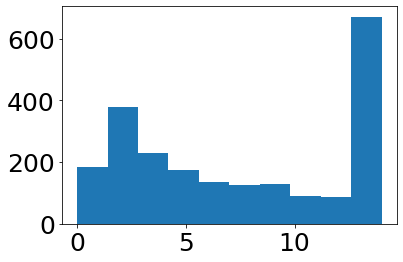

In [22]:
plt.hist(best_ages,range=(0.,14.0))

In [38]:
calc_clus_ages = np.array([])
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(best_ages!=999999.0))
    calc_clus_ages = np.append(calc_clus_ages,np.median(best_ages[clus]))
    
print(calc_clus_ages)

[ 3.13877859 13.97494155  2.50277119 12.93746892  7.37496562 13.97494156
  8.3619804   2.82494166 13.97494158  7.23745543  4.1999421   3.33942769
 13.94986489  9.75000861 12.92498371 11.57719069  5.36145041  2.46124648
 13.96157115  2.38338764  4.9750798   5.31242847  9.10179939  4.13631221
  7.84993962  5.67492339  3.14988722  4.91243038 13.69998213  9.32491757]


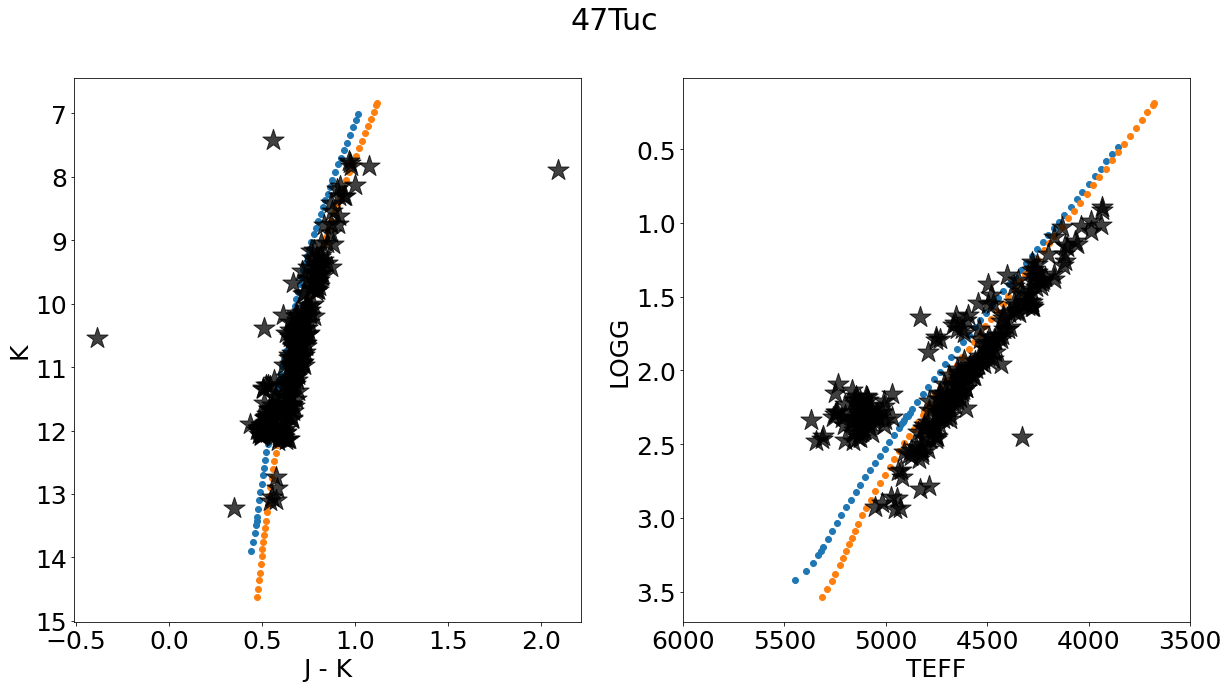

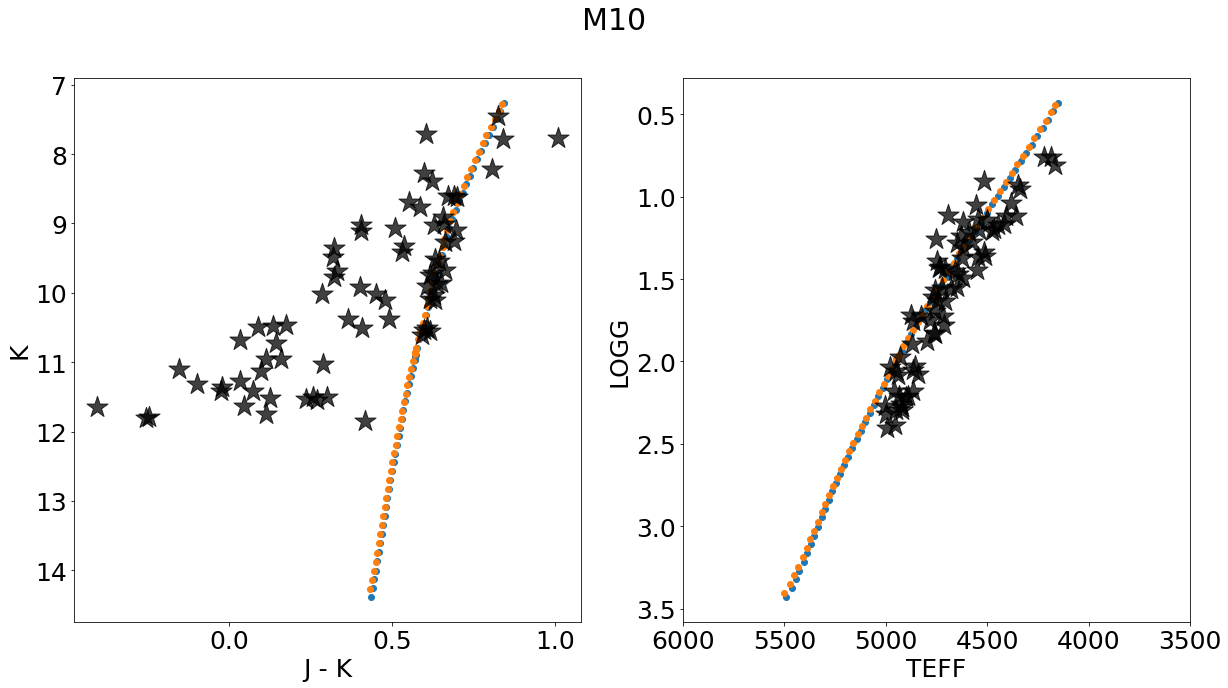

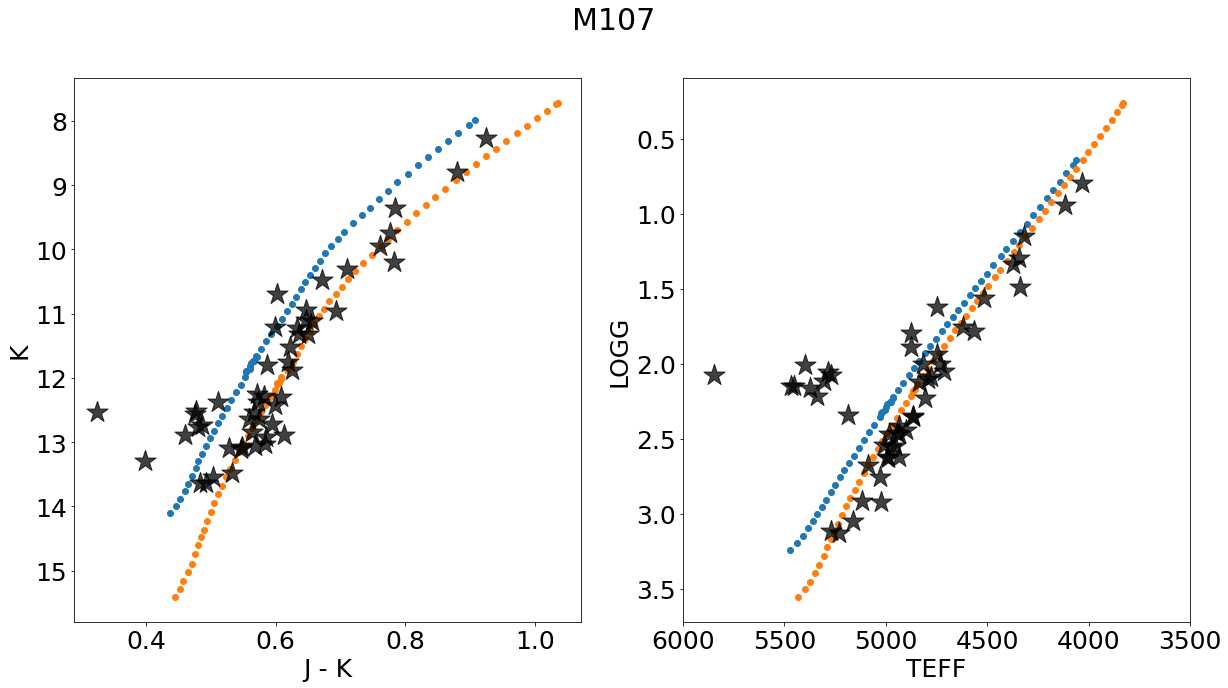

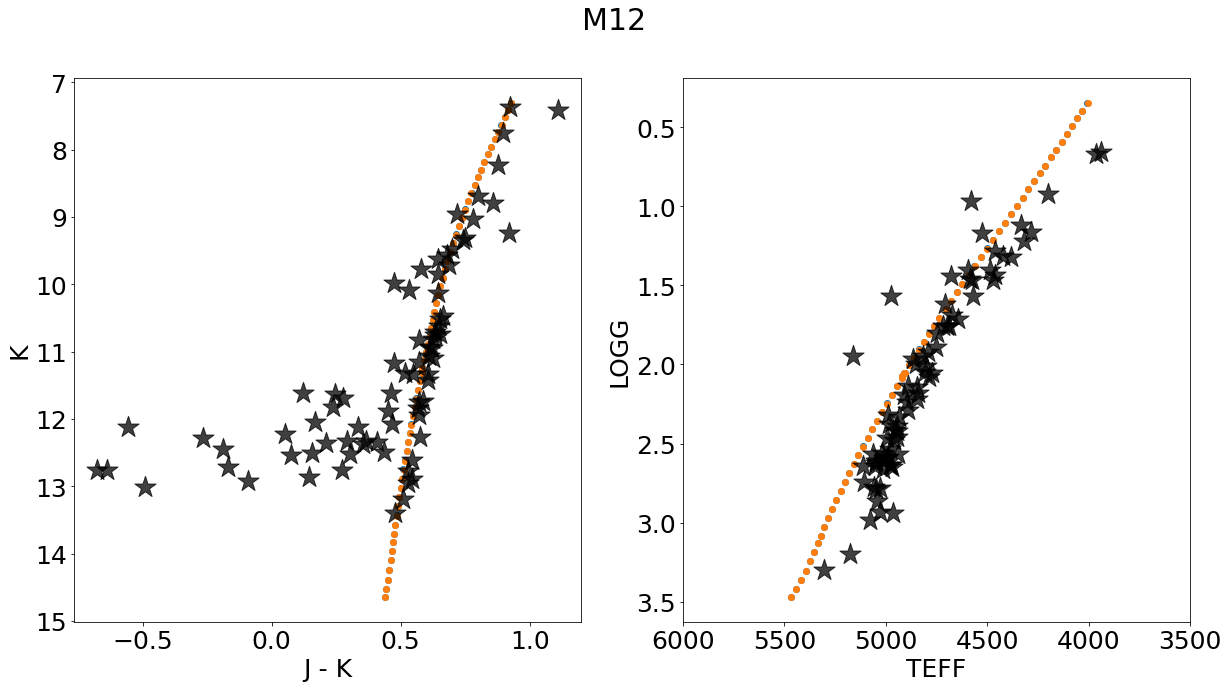

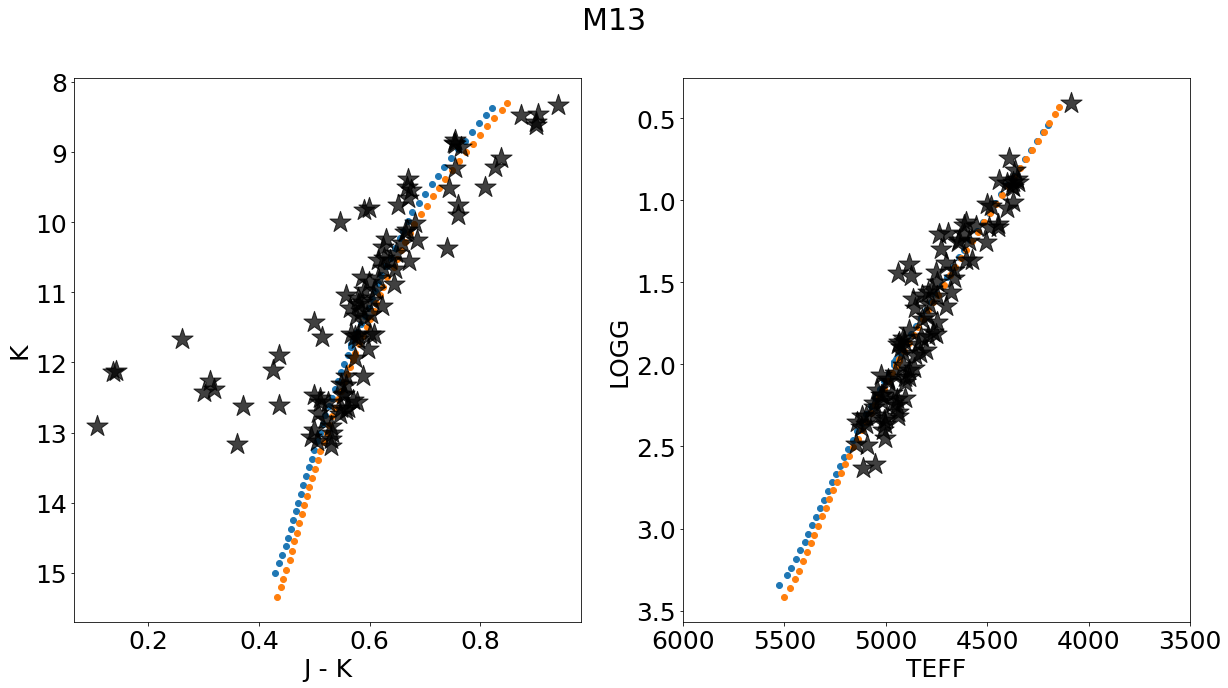

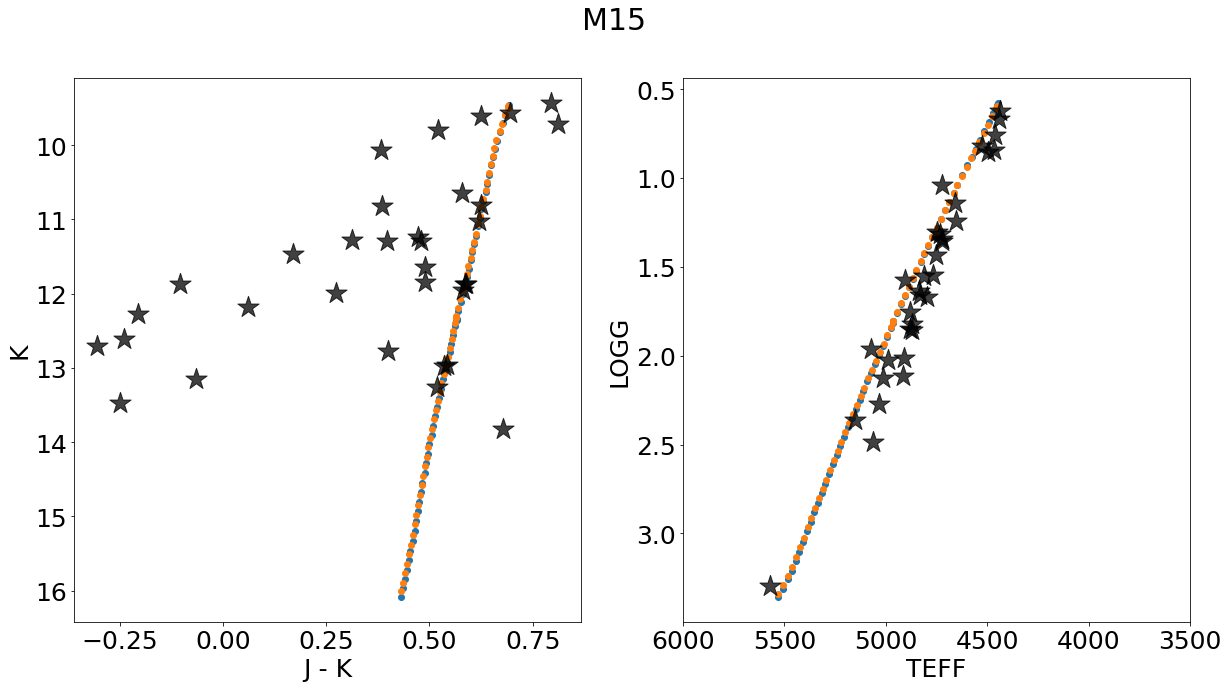

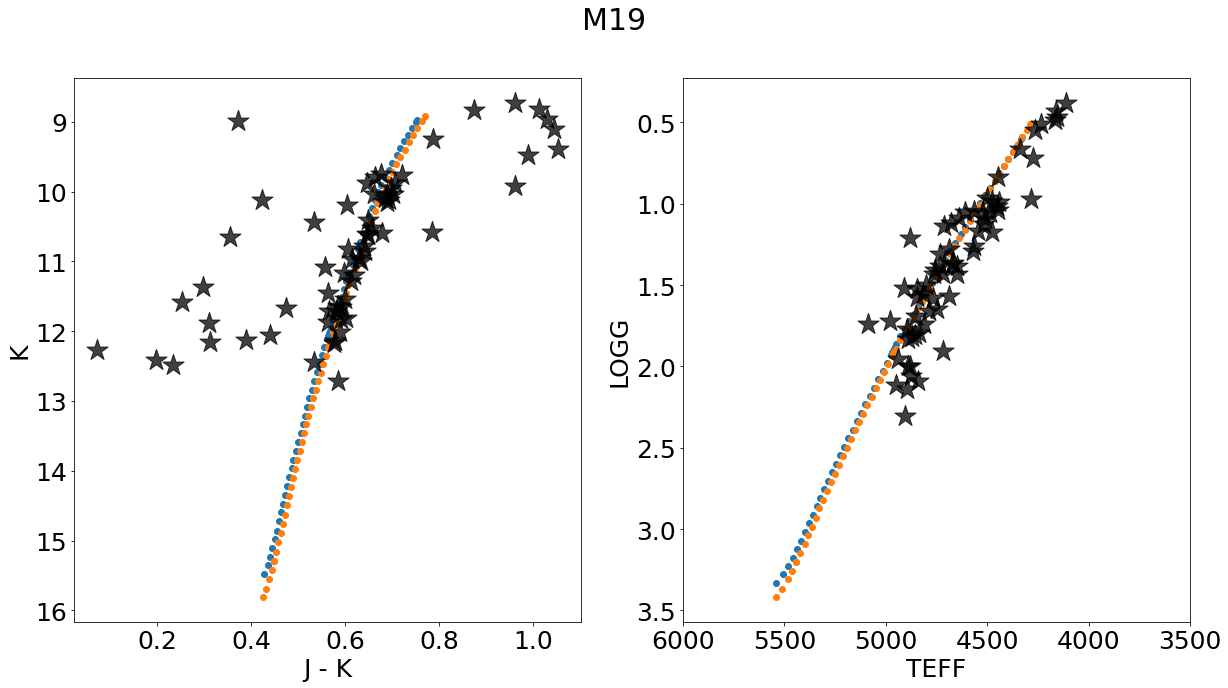

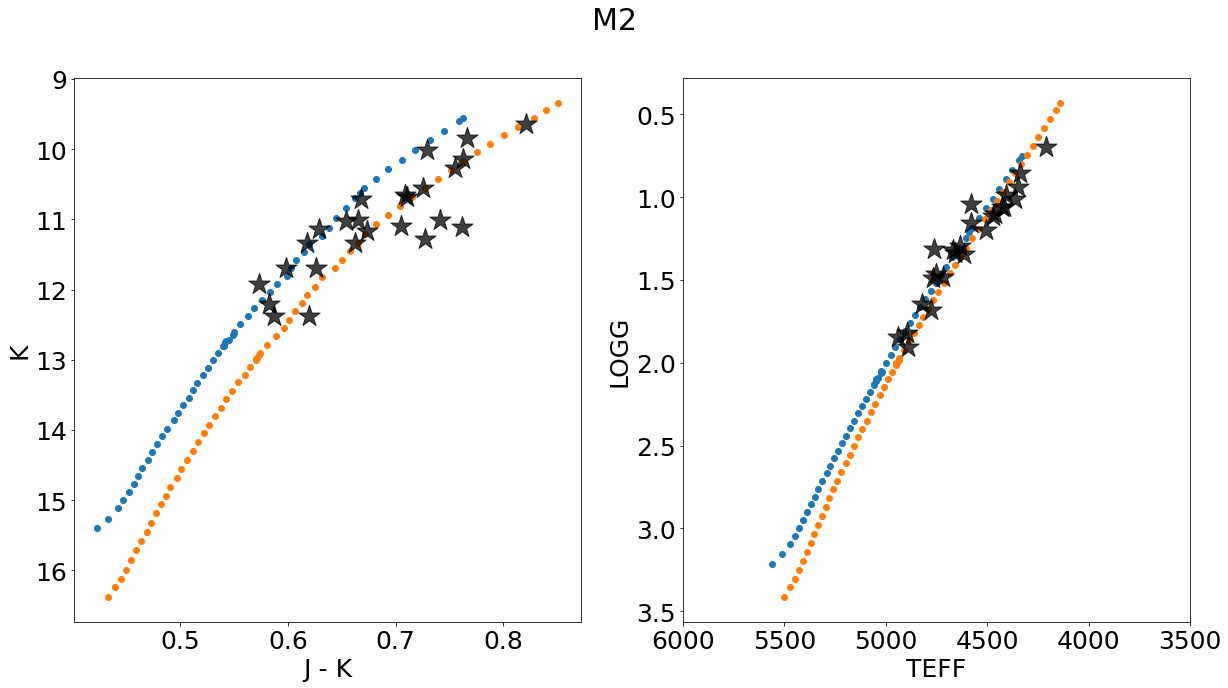

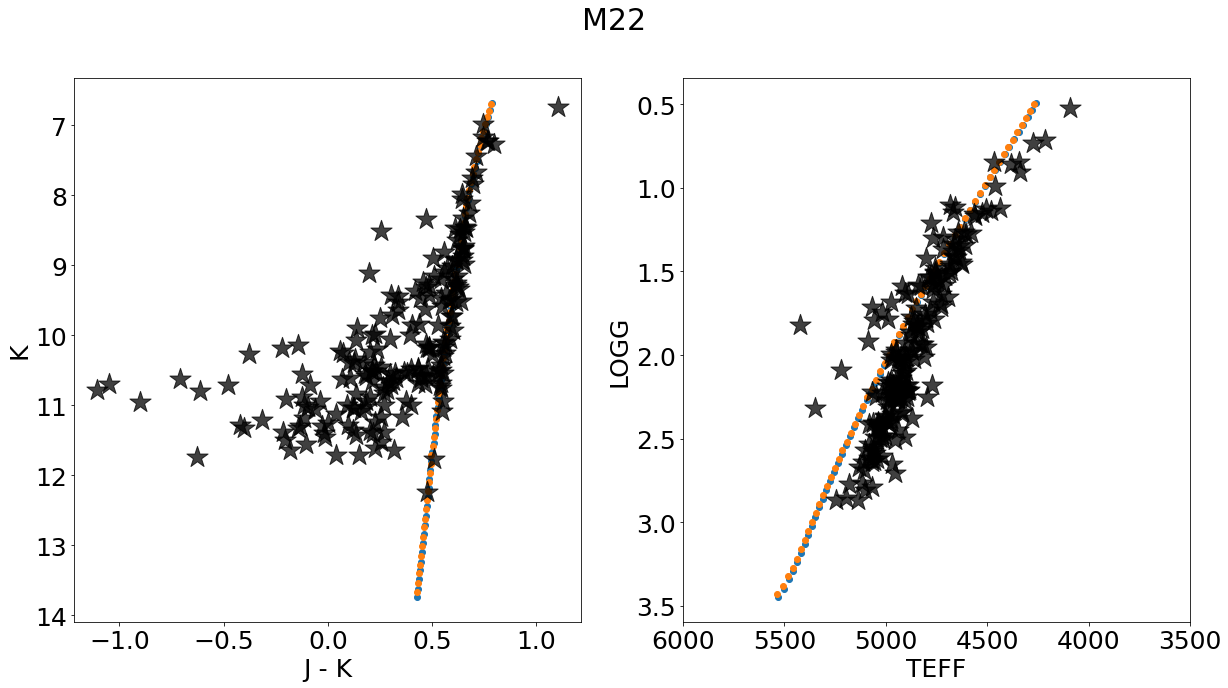

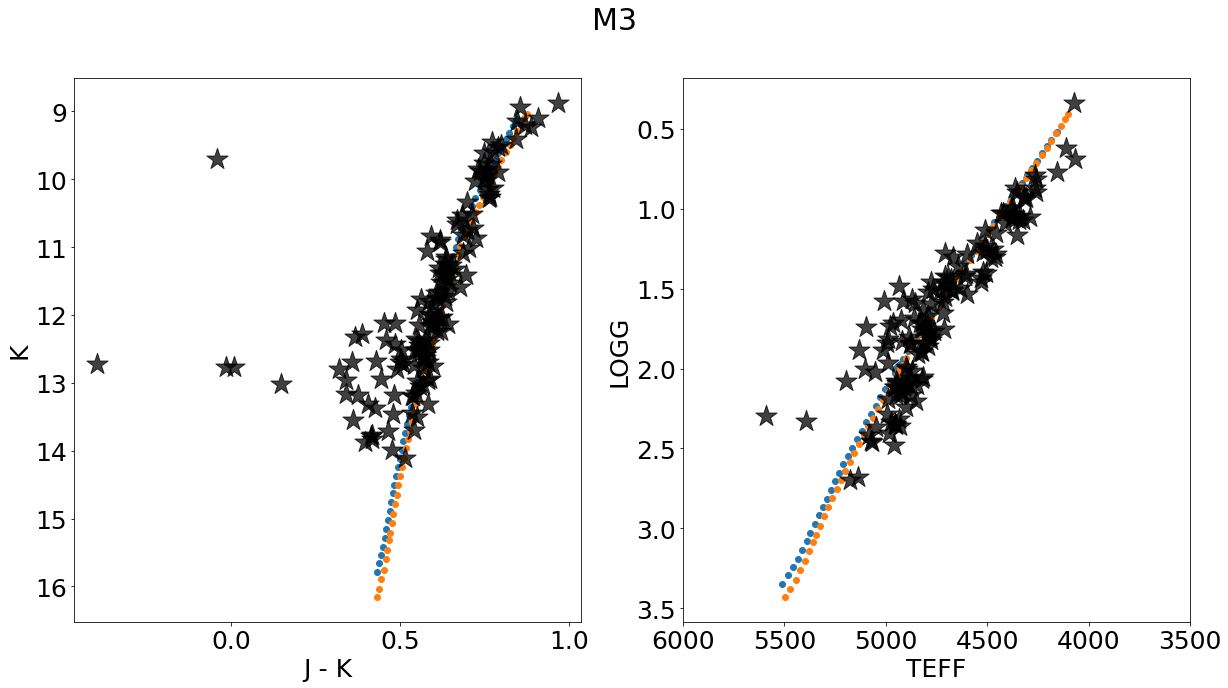

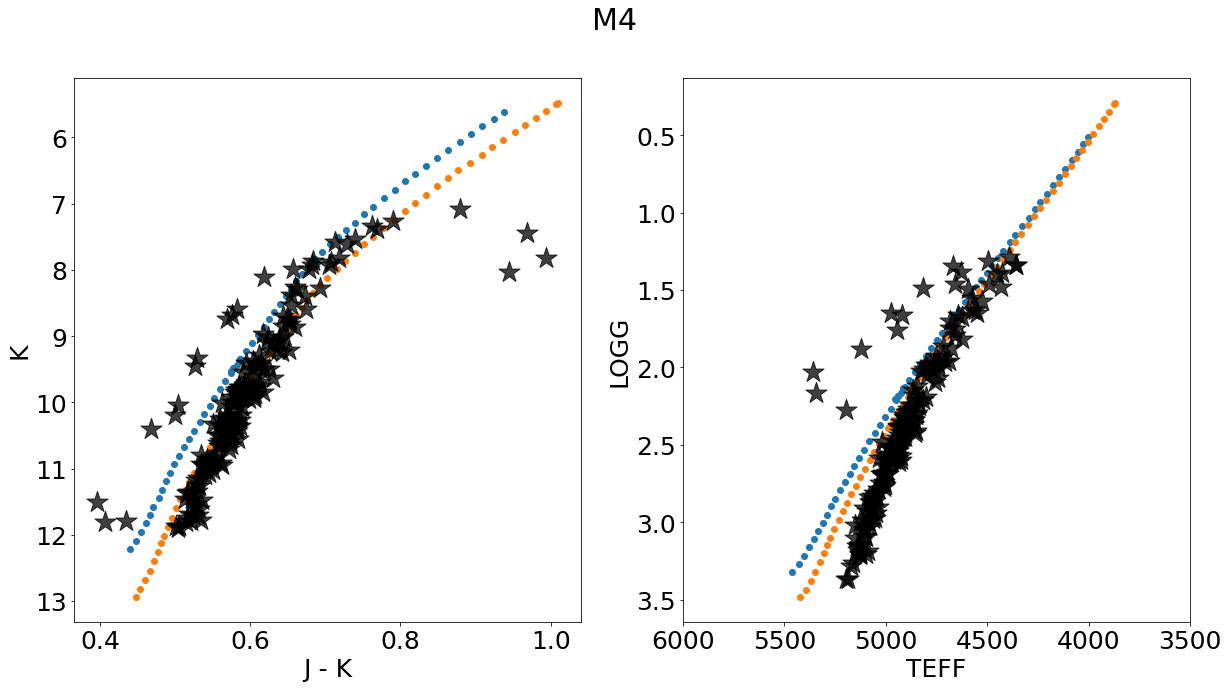

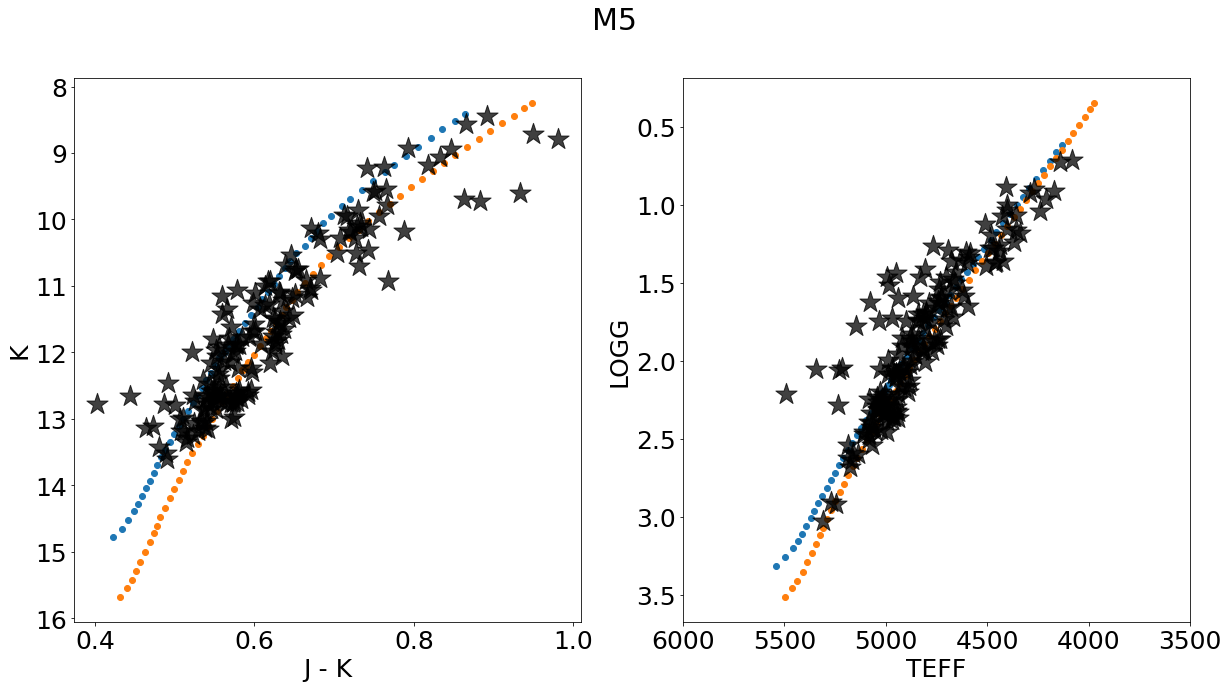

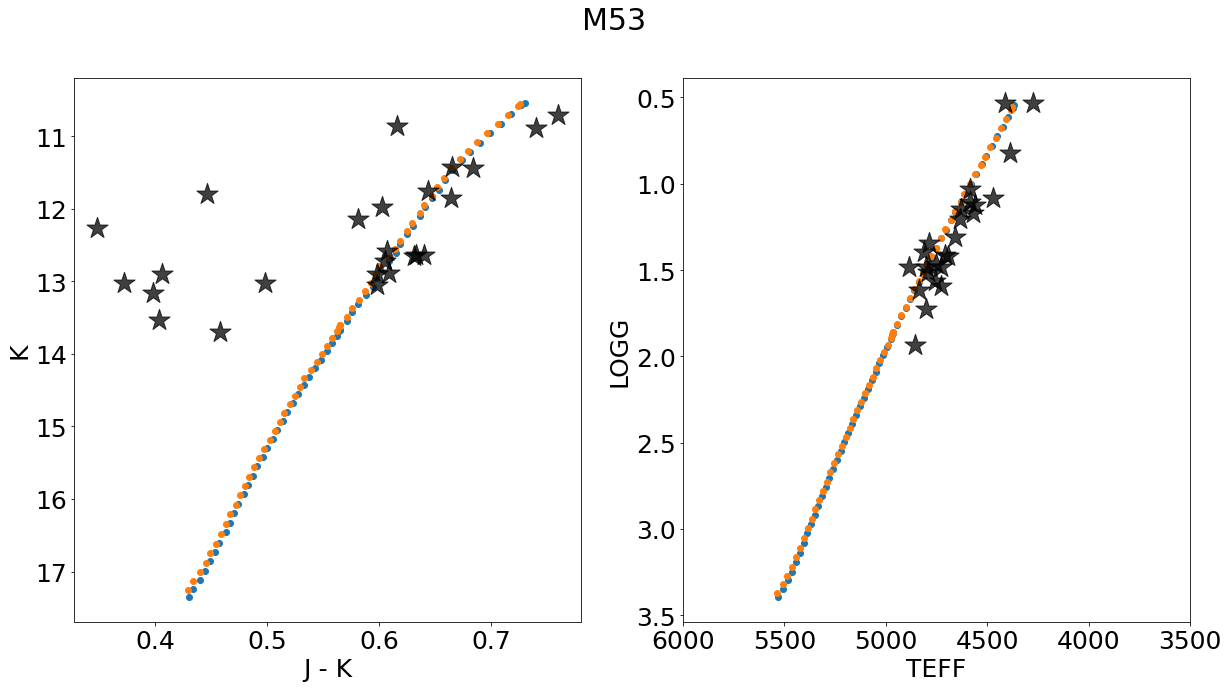

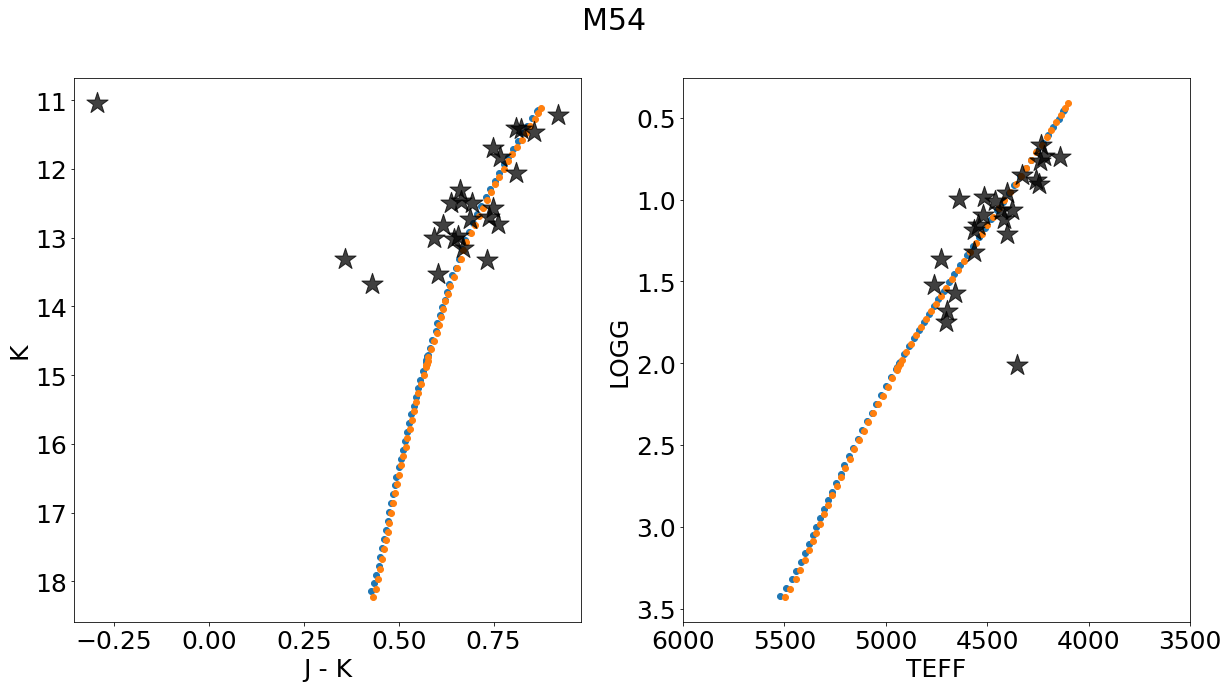

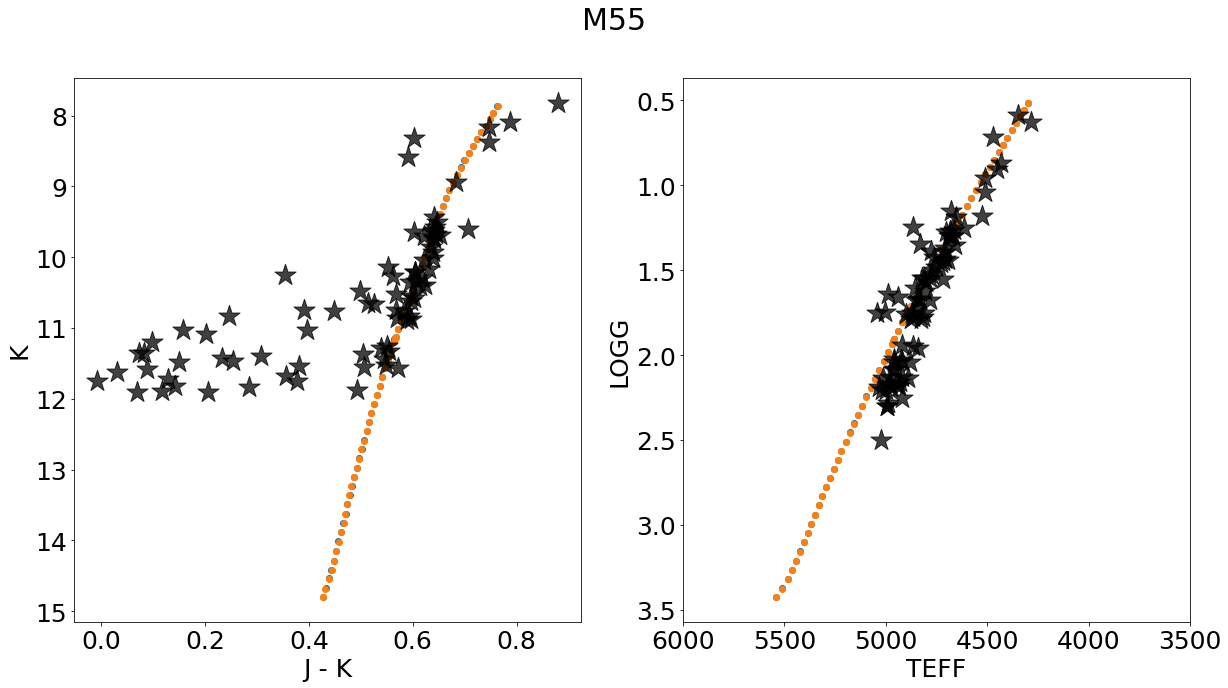

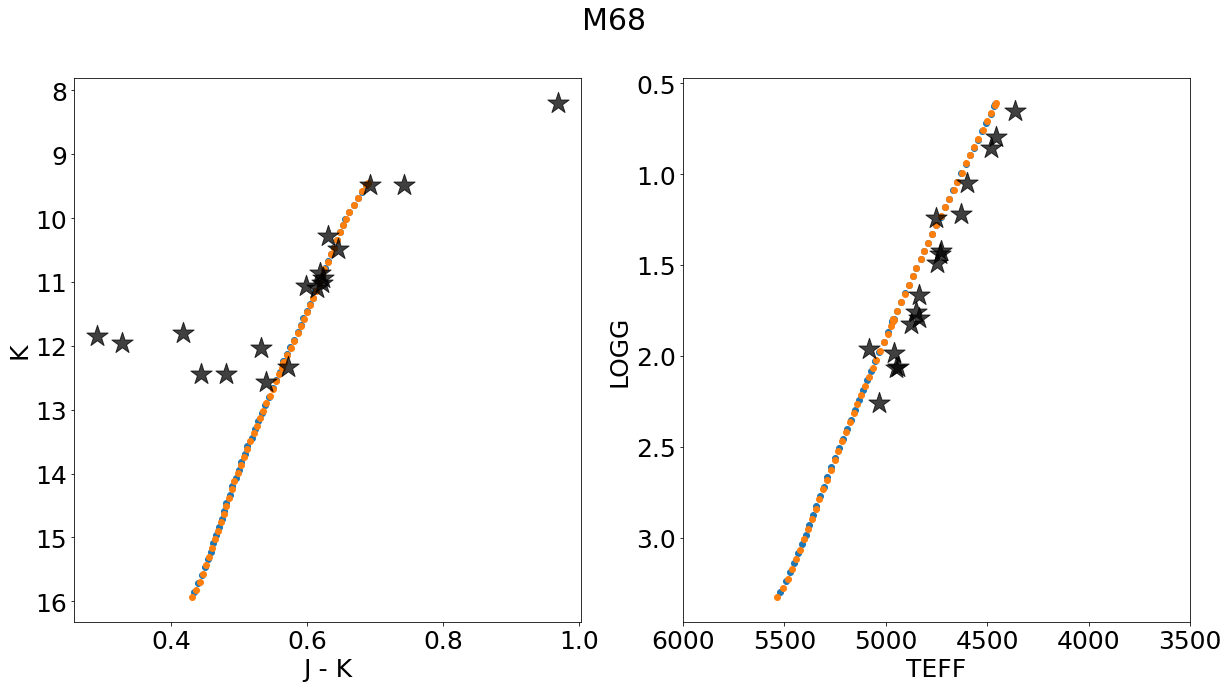

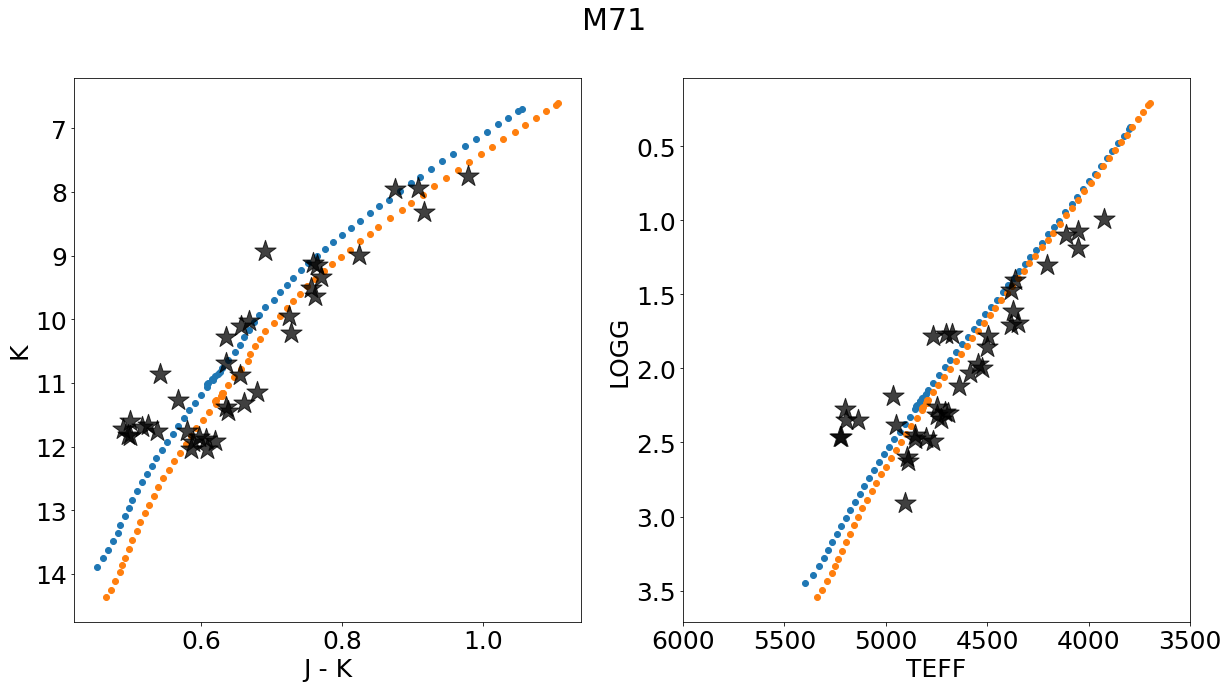

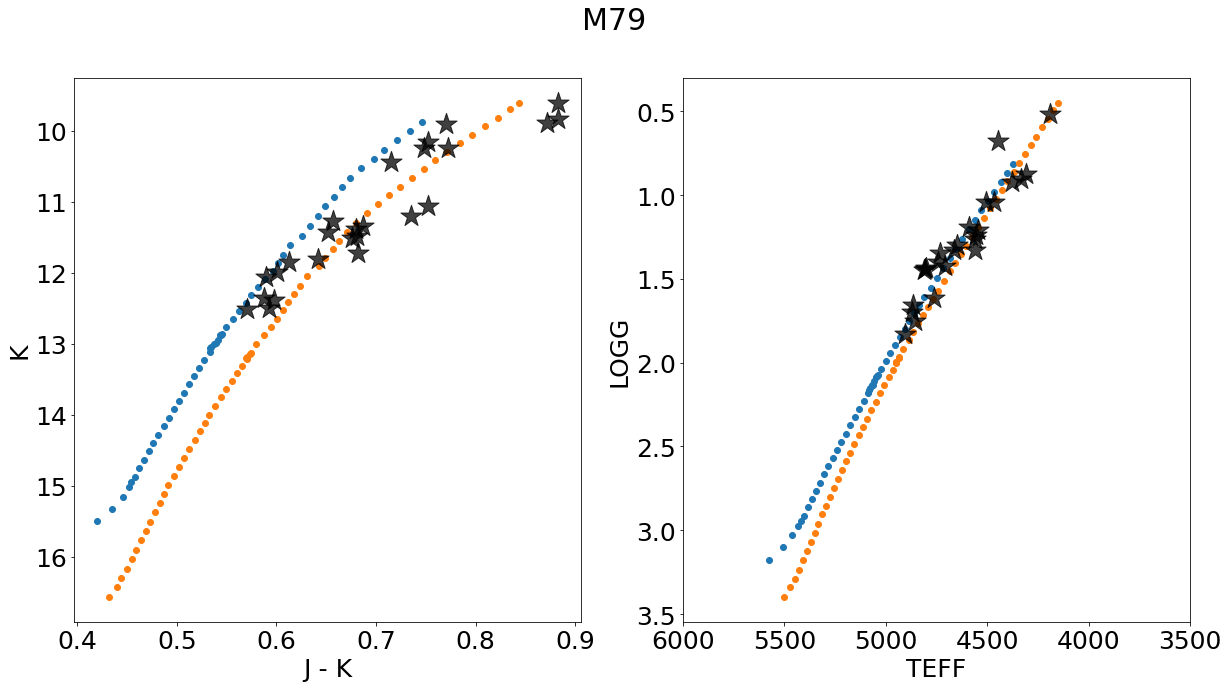

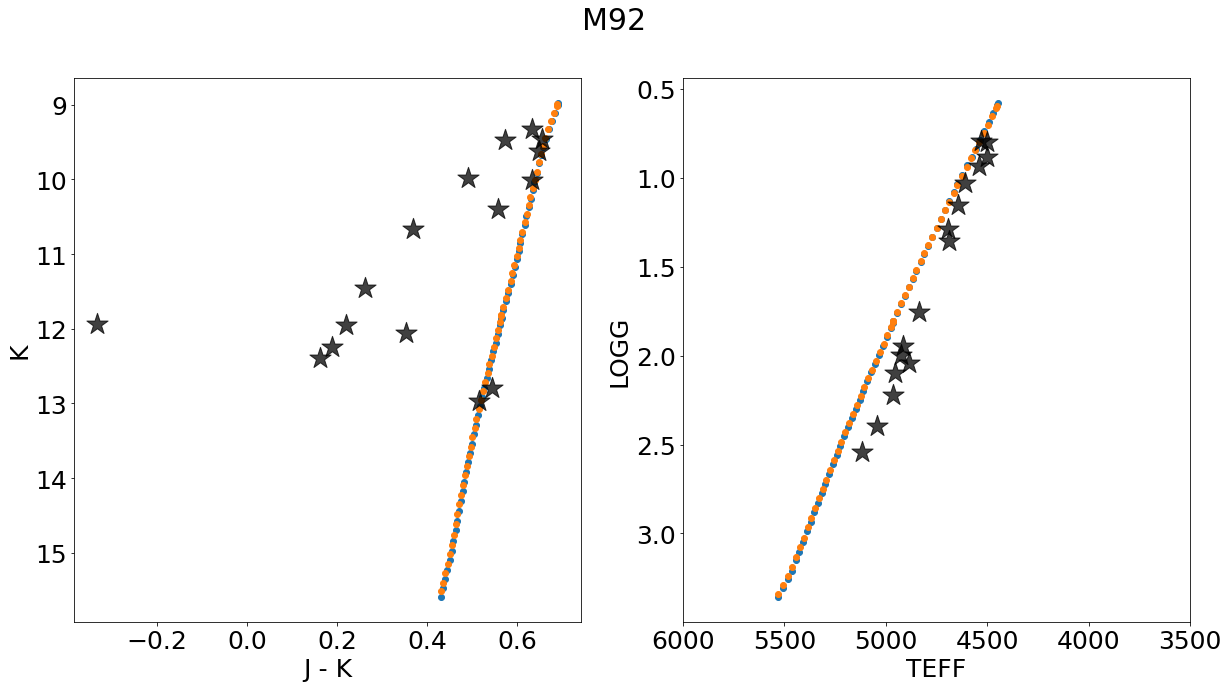

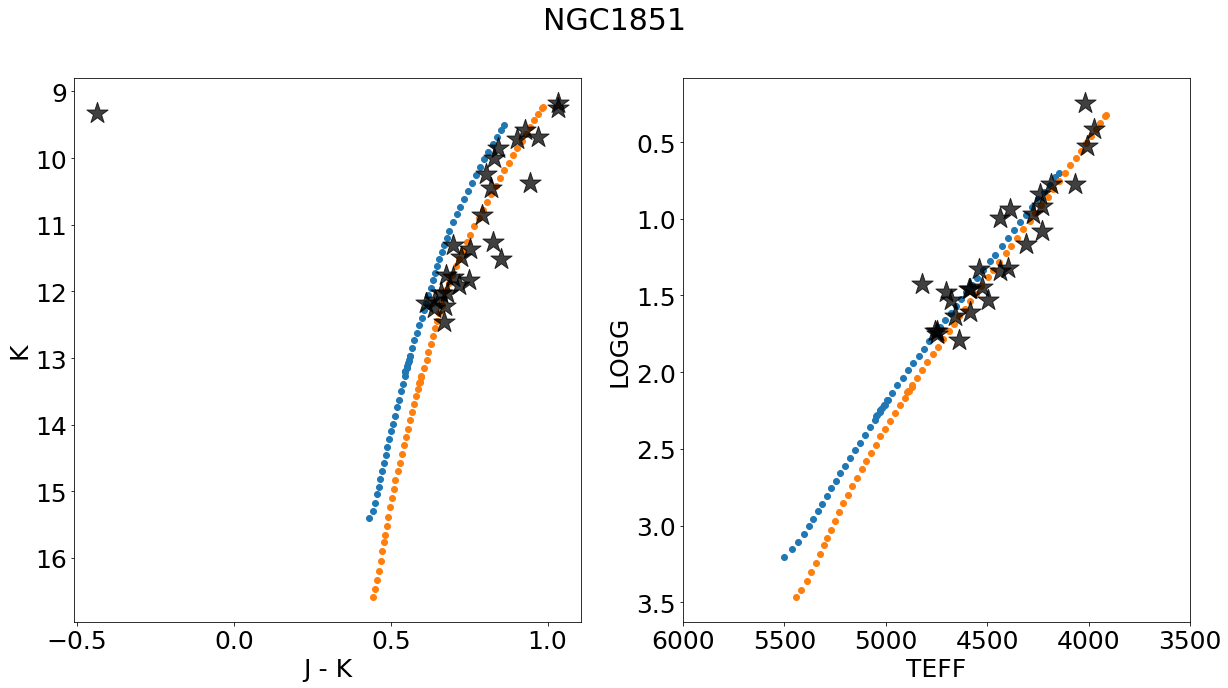

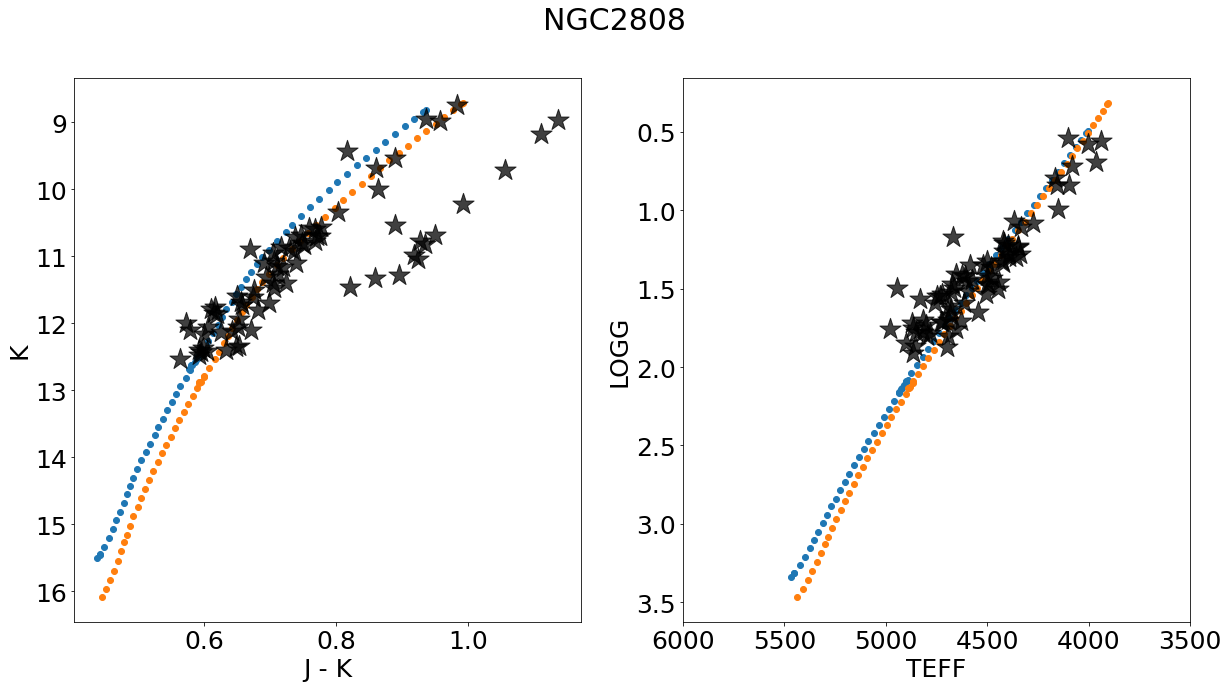

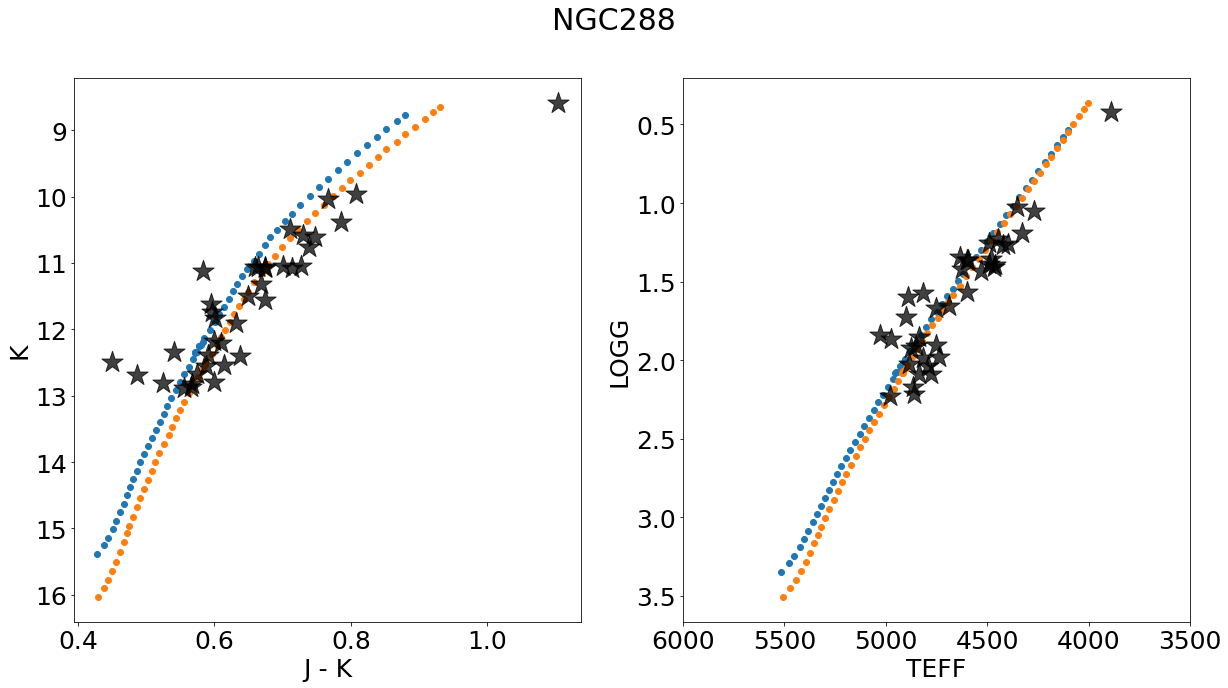

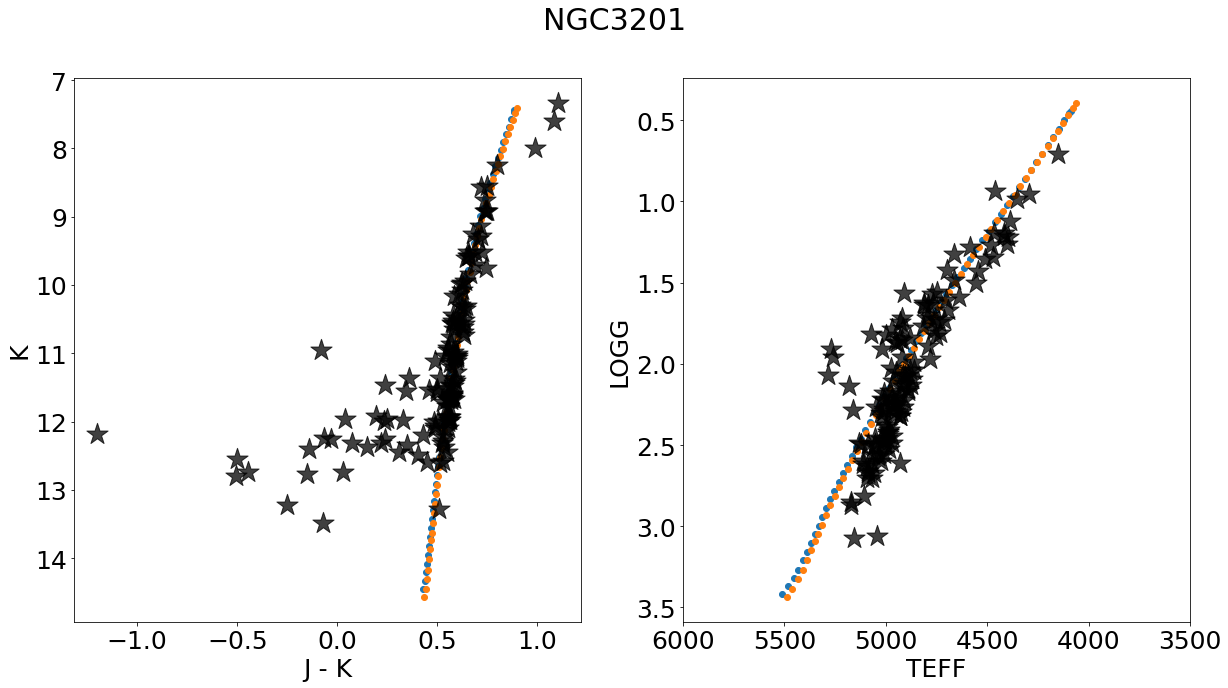

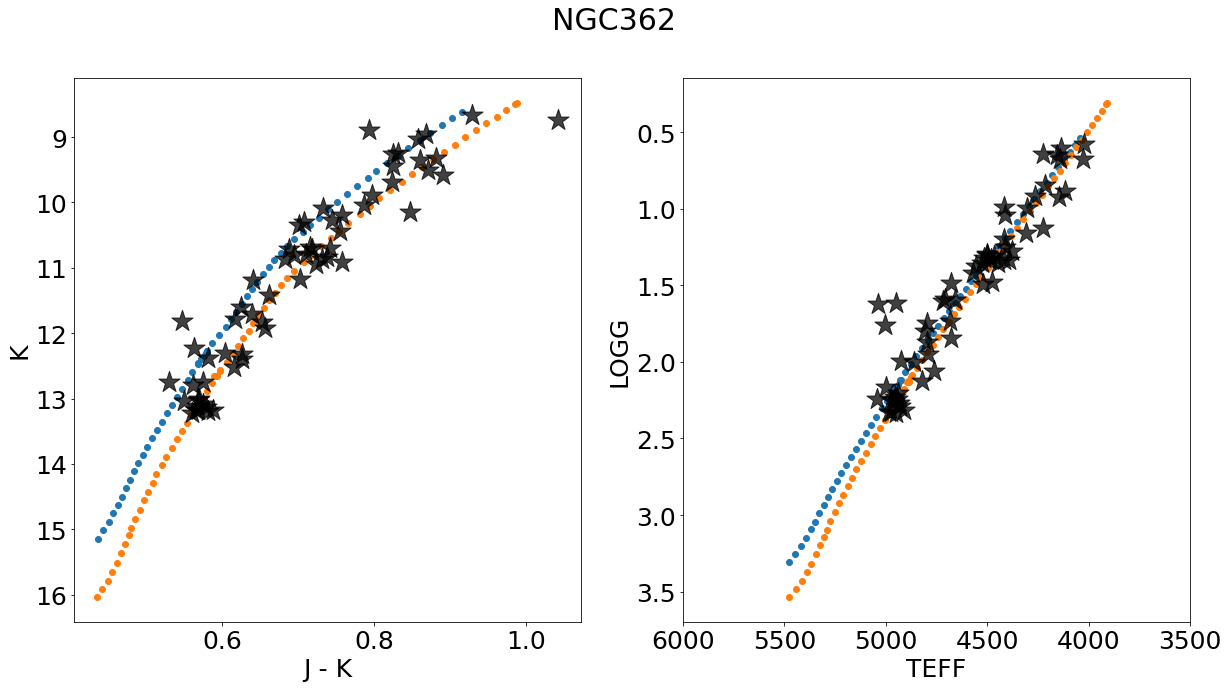

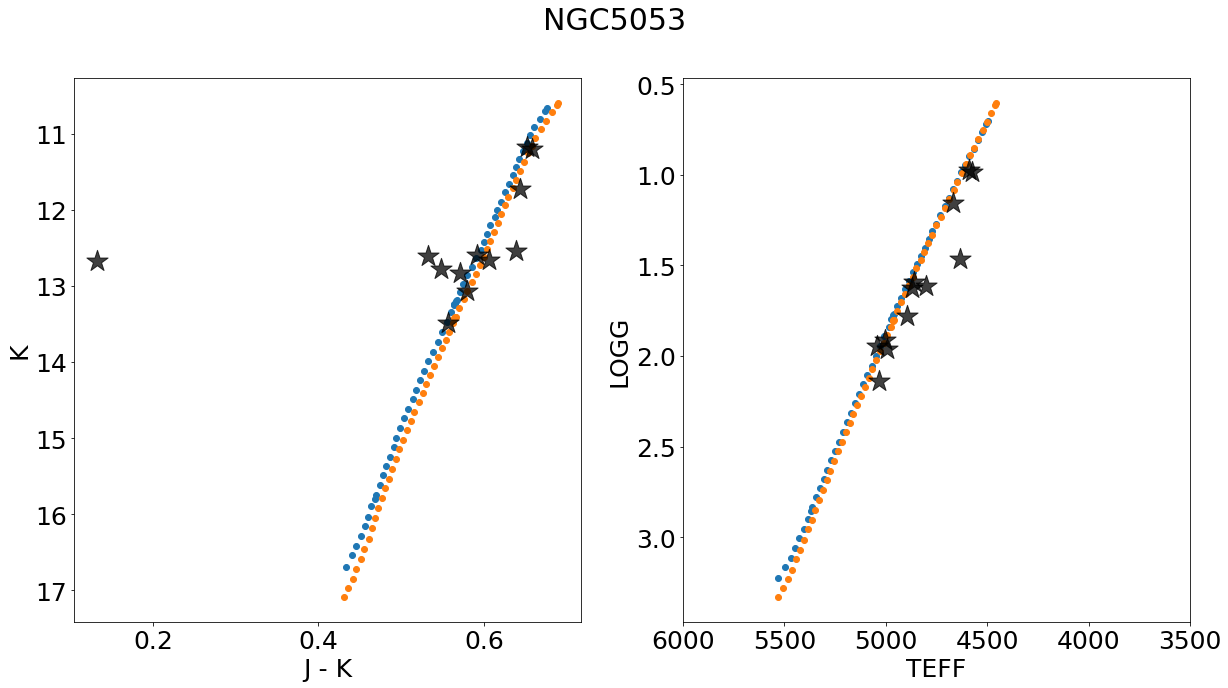

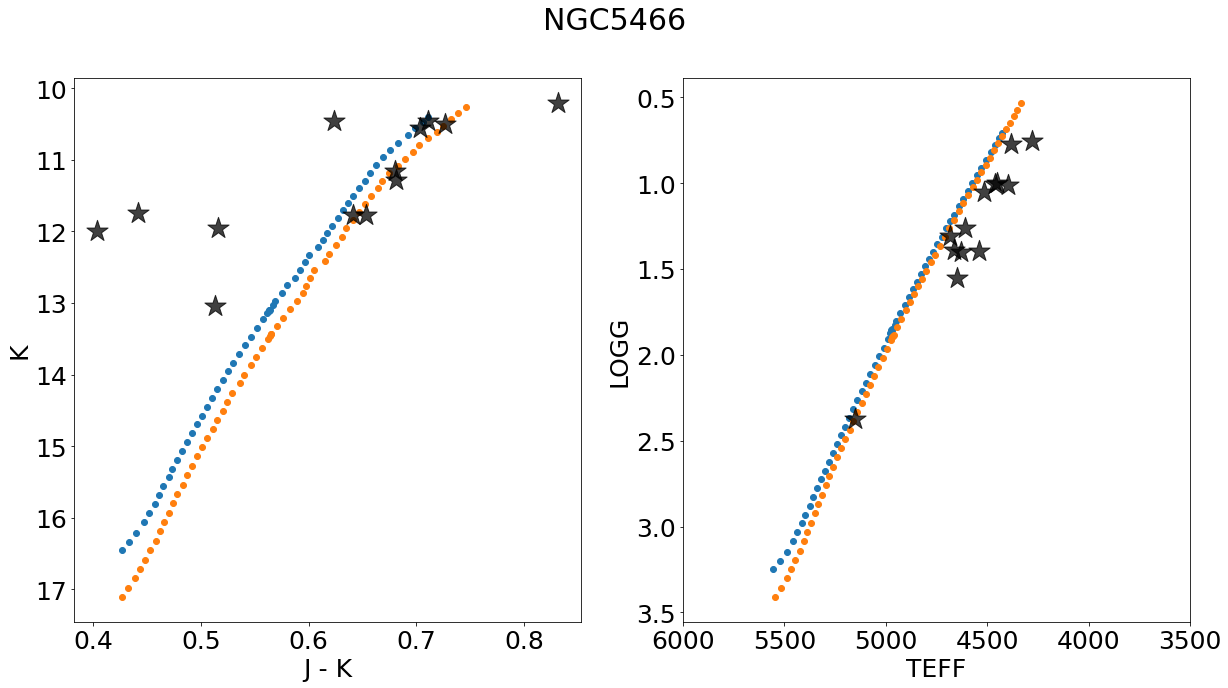

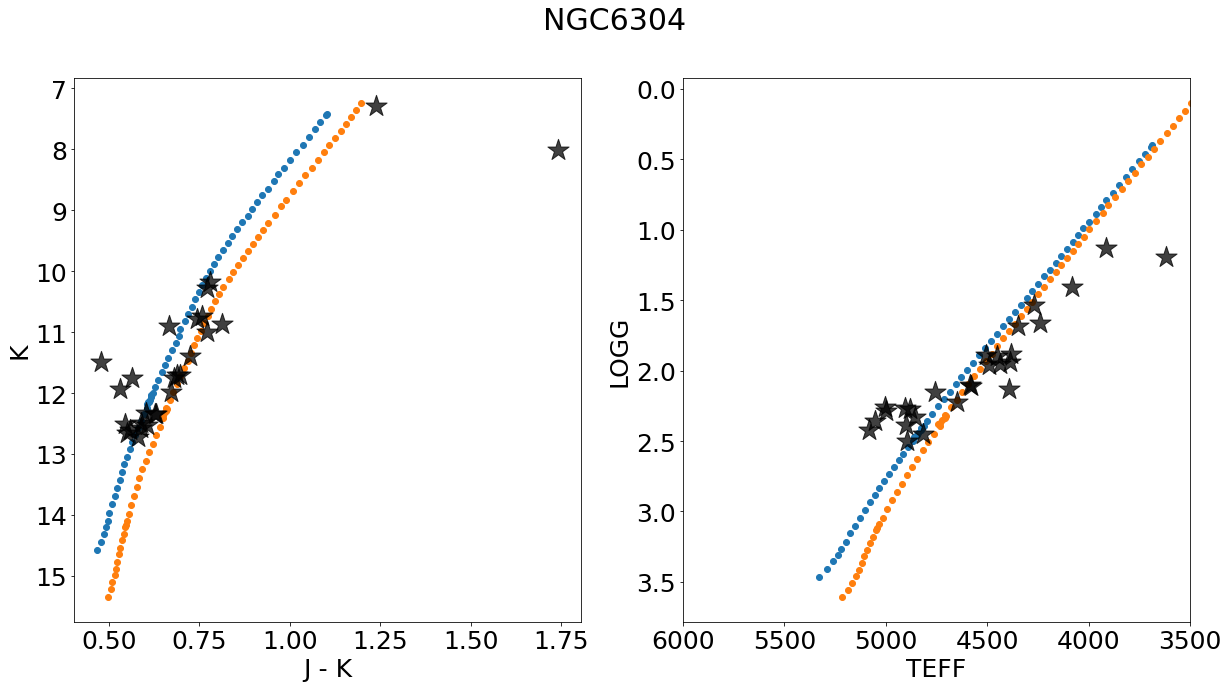

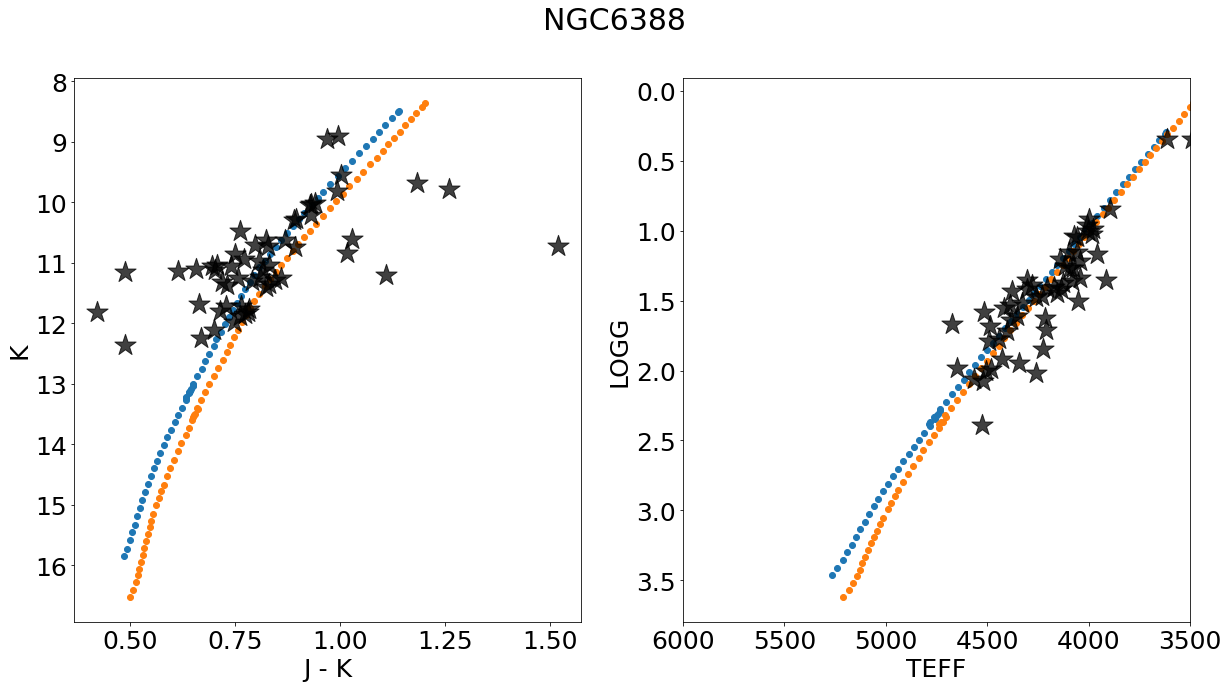

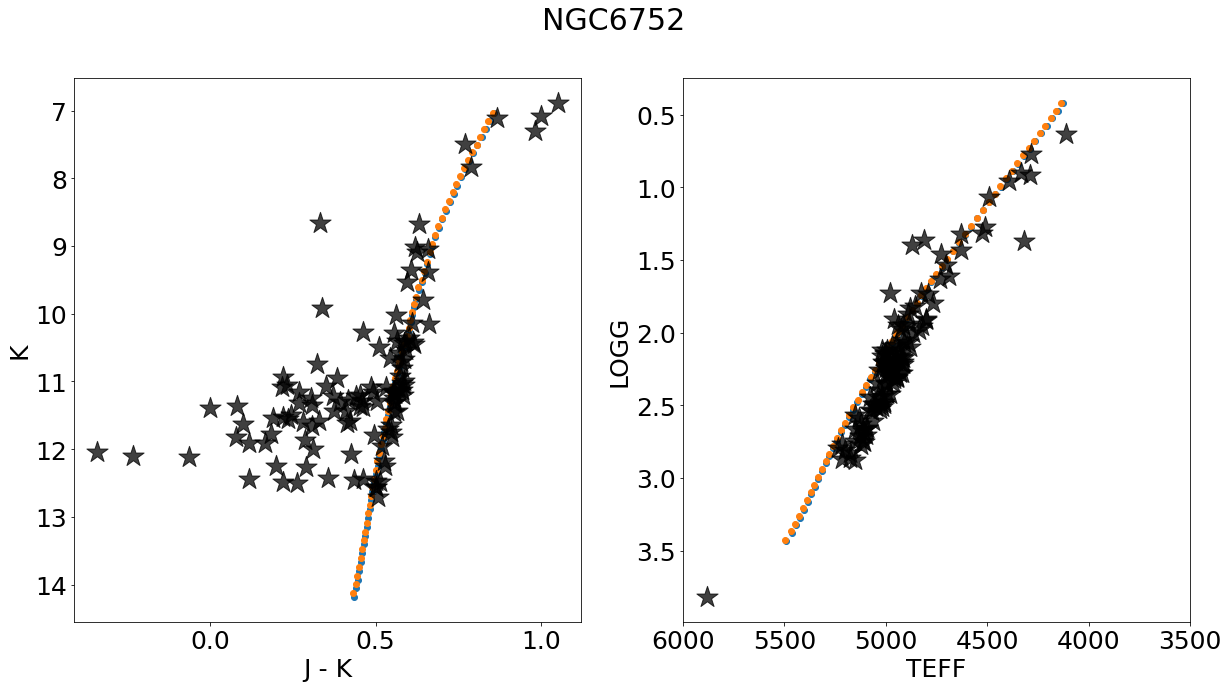

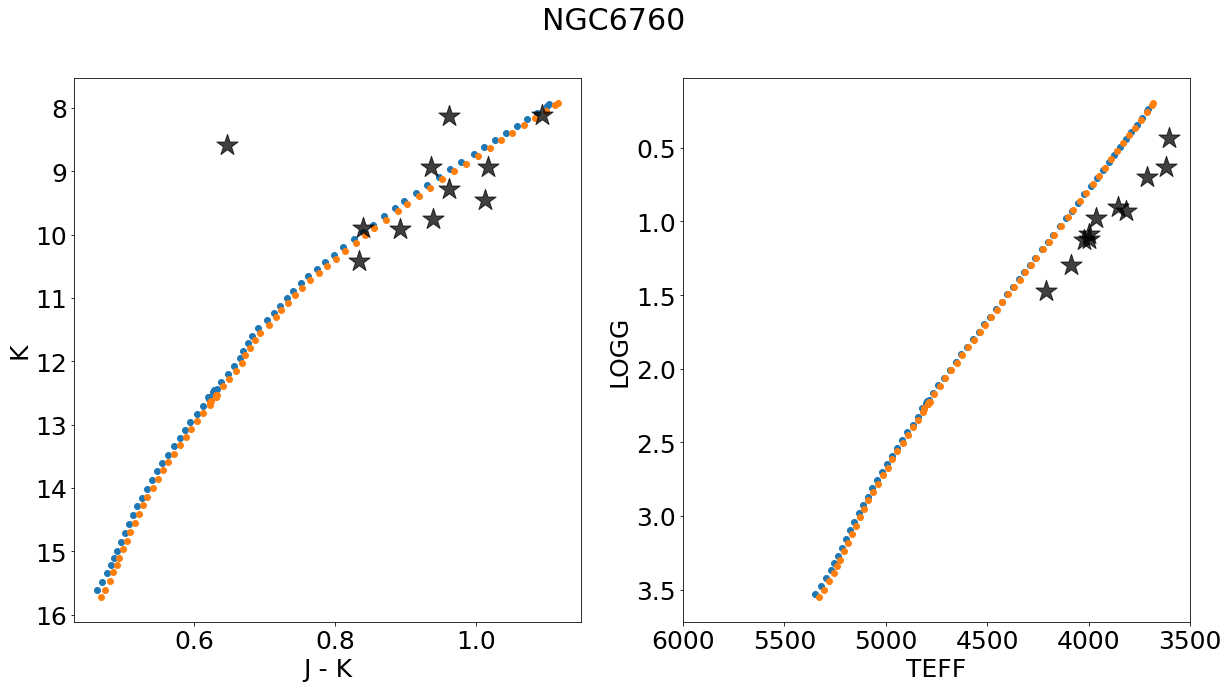

In [54]:
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(best_aks!=999999.0))
    isopick = np.where((massive['MH']==closest(massive['MH'],np.median(shiftfeh[clus])))&
                       (massive['logAge']==closest(massive['logAge'],np.log10(calc_clus_ages[i]*10**9))))
    
    isopick2 = np.where((massive['MH']==closest(massive['MH'],np.median(shiftfeh[clus])))&
                       (massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9))))
    
    fig, ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter((massive['Jmag']-massive['Ksmag'])[isopick],
                  massive['Ksmag'][isopick]+5.*np.log10(harris_dist[i])-5.0,cmap='tab20',zorder=0)
    ax[0].scatter((massive['Jmag']-massive['Ksmag'])[isopick2],
                  massive['Ksmag'][isopick2]+5.*np.log10(harris_dist[i])-5.0,cmap='tab20',zorder=0)
    ax[0].scatter((gcsdr17['J']-gcsdr17['K']-best_aks*ejk_ak)[clus],gcsdr17['K'][clus]-best_aks[clus],c='k',
                  marker='*',s=500,zorder=1,alpha=0.75)
    ax[0].invert_yaxis()
    ax[0].set_xlabel(r'J - K')
    ax[0].set_ylabel(r'K')
    
    ax[1].scatter(10**massive['logTe'][isopick],massive['logg'][isopick],cmap='tab20',zorder=0)
    ax[1].scatter(10**massive['logTe'][isopick2],massive['logg'][isopick2],cmap='tab20',zorder=0)
    ax[1].scatter(gcsdr17['TEFF'][clus],gcsdr17['LOGG'][clus],c='k',marker='*',s=500,zorder=1,alpha=0.75)
    ax[1].set_xlim(3500,6000)
    ax[1].set_xlabel(r'TEFF')
    ax[1].set_ylabel(r'LOGG')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    
    plt.suptitle(r'{}'.format(gcs_clus[i]))
#     plt.savefig('{}CMDHR.pdf'.format(gcs_clus[i]),bbox_inches='tight')
#     plt.title(r'K, J - K; {}; Color as Age'.format(gcs_clus[i]))
    plt.show()

In [50]:
calc_clus_ages

array([ 3.13877859, 13.97494155,  2.50277119, 12.93746892,  7.37496562,
       13.97494156,  8.3619804 ,  2.82494166, 13.97494158,  7.23745543,
        4.1999421 ,  3.33942769, 13.94986489,  9.75000861, 12.92498371,
       11.57719069,  5.36145041,  2.46124648, 13.96157115,  2.38338764,
        4.9750798 ,  5.31242847,  9.10179939,  4.13631221,  7.84993962,
        5.67492339,  3.14988722,  4.91243038, 13.69998213,  9.32491757])

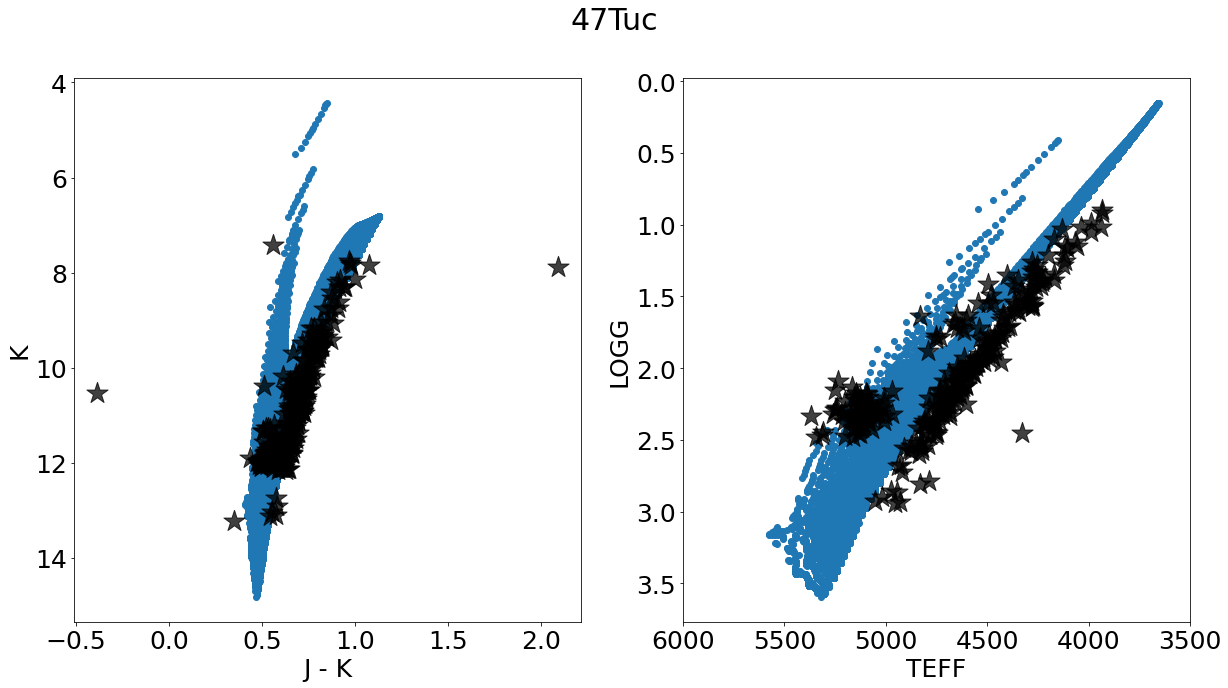

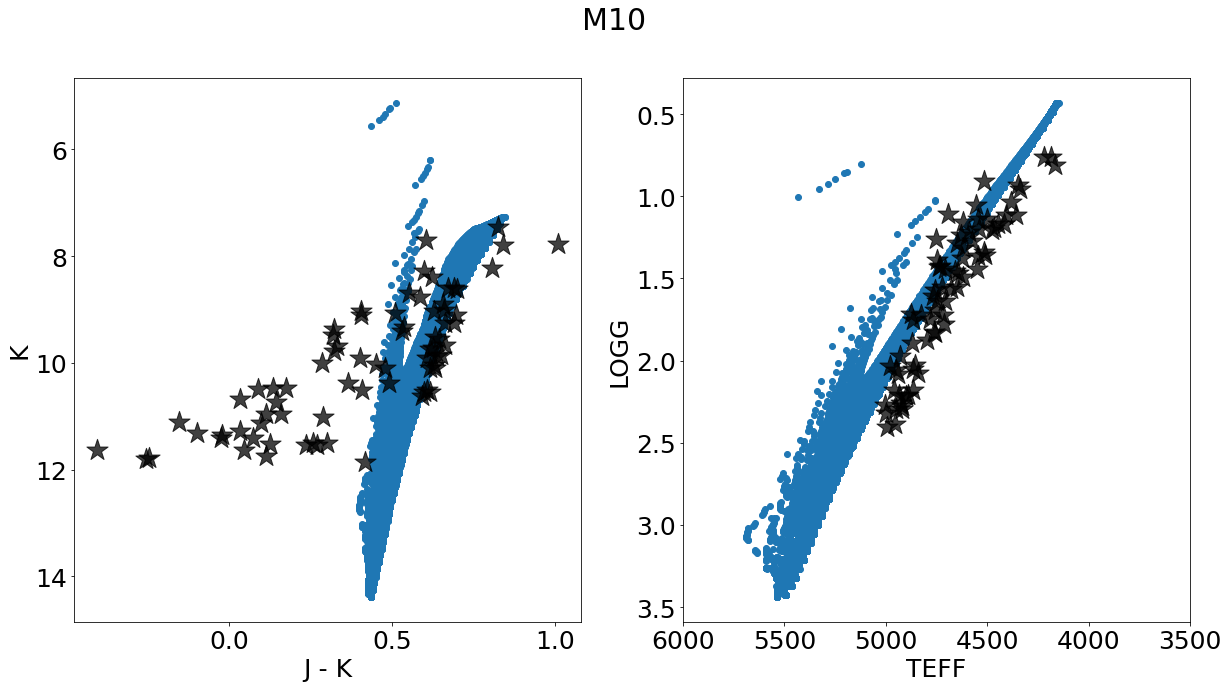

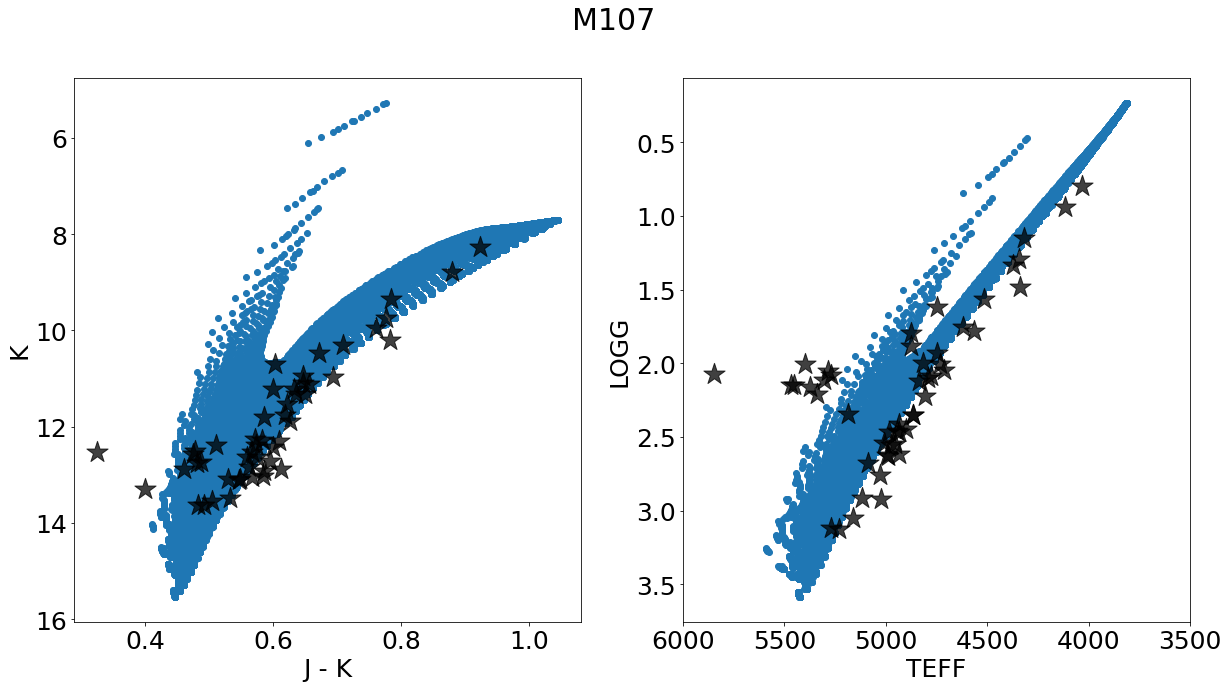

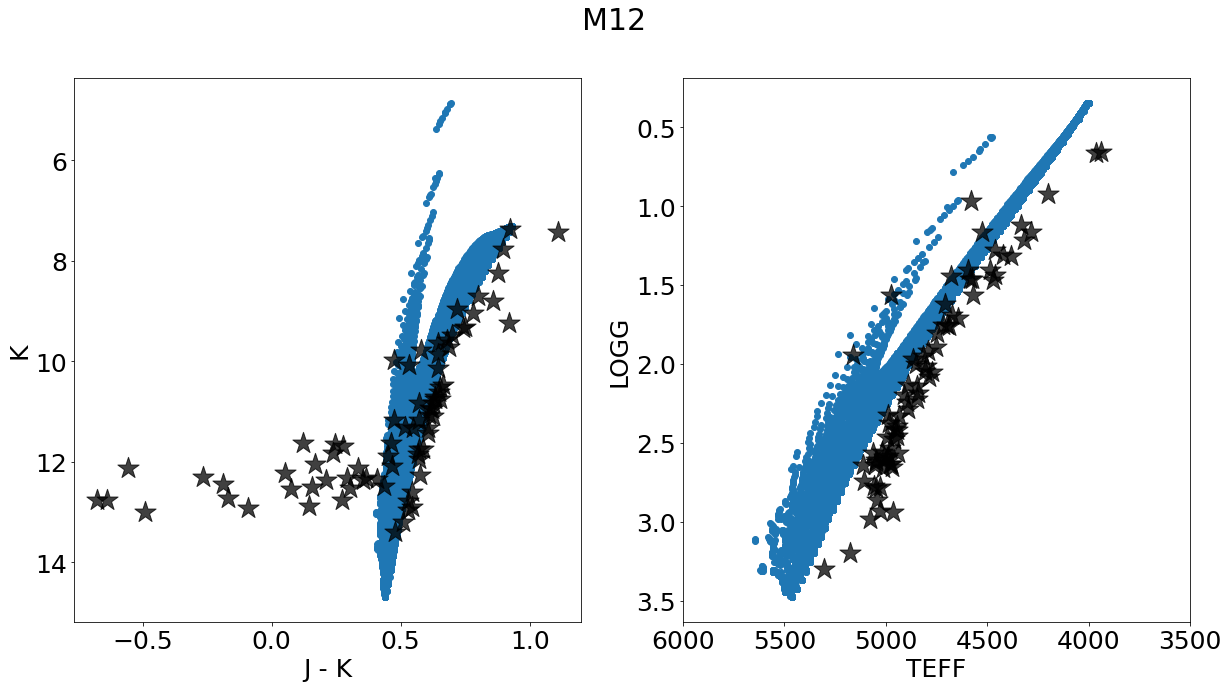

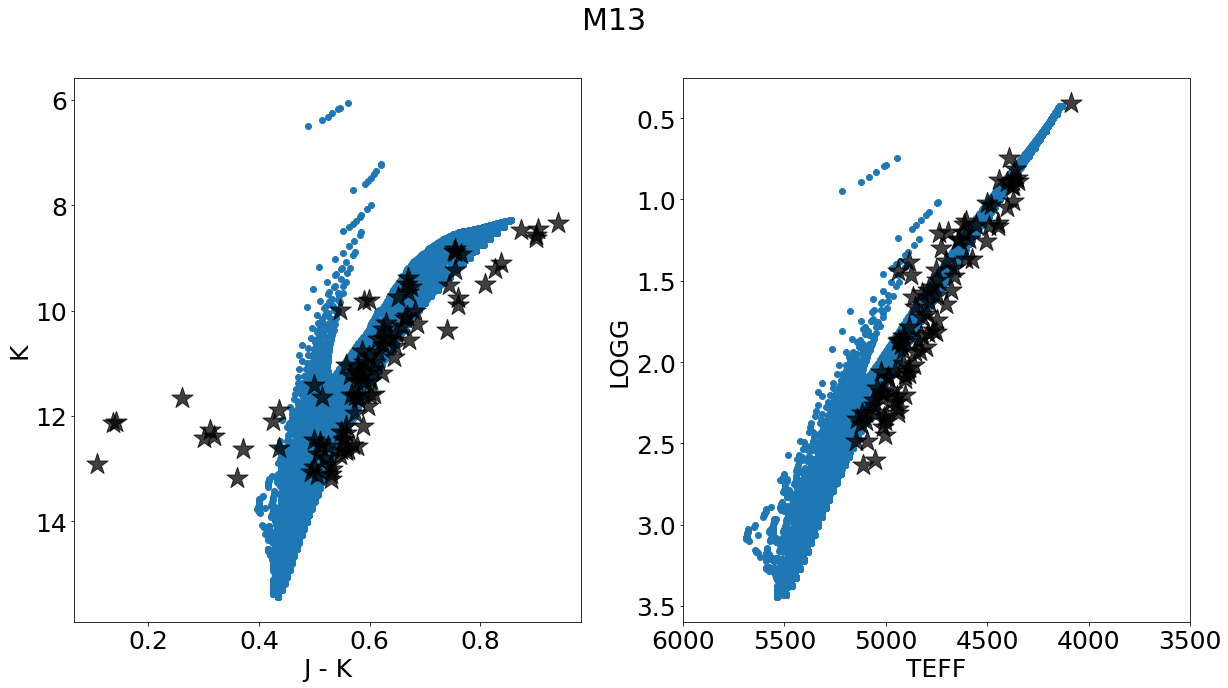

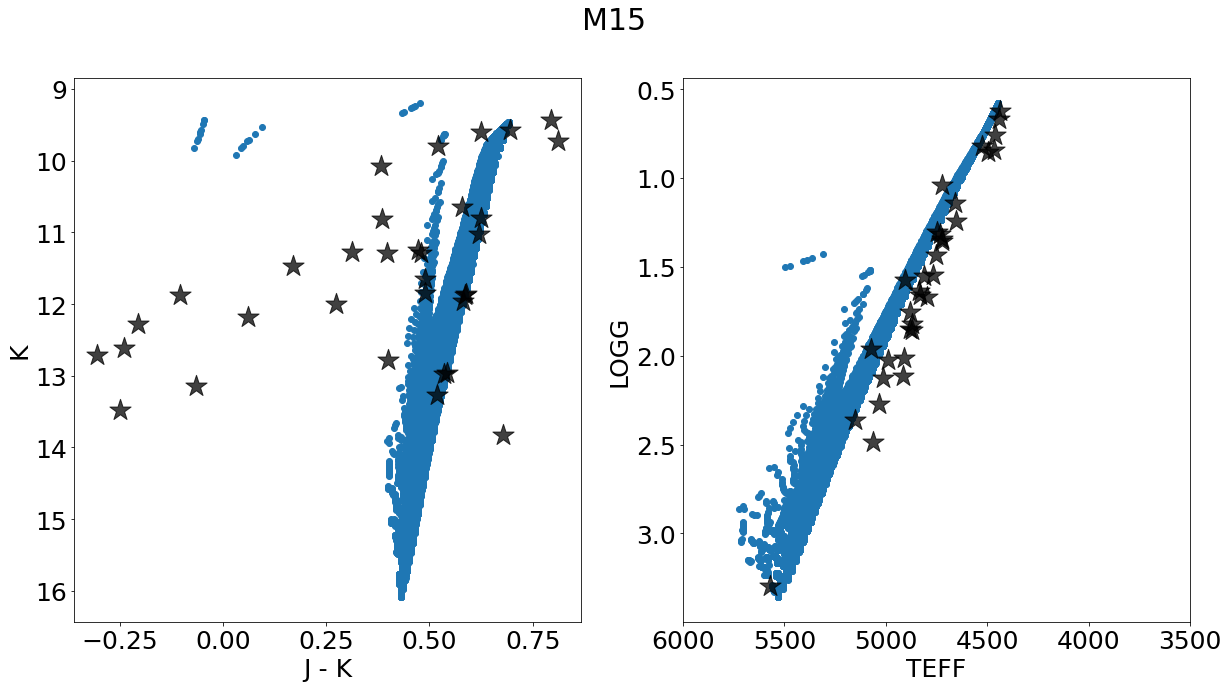

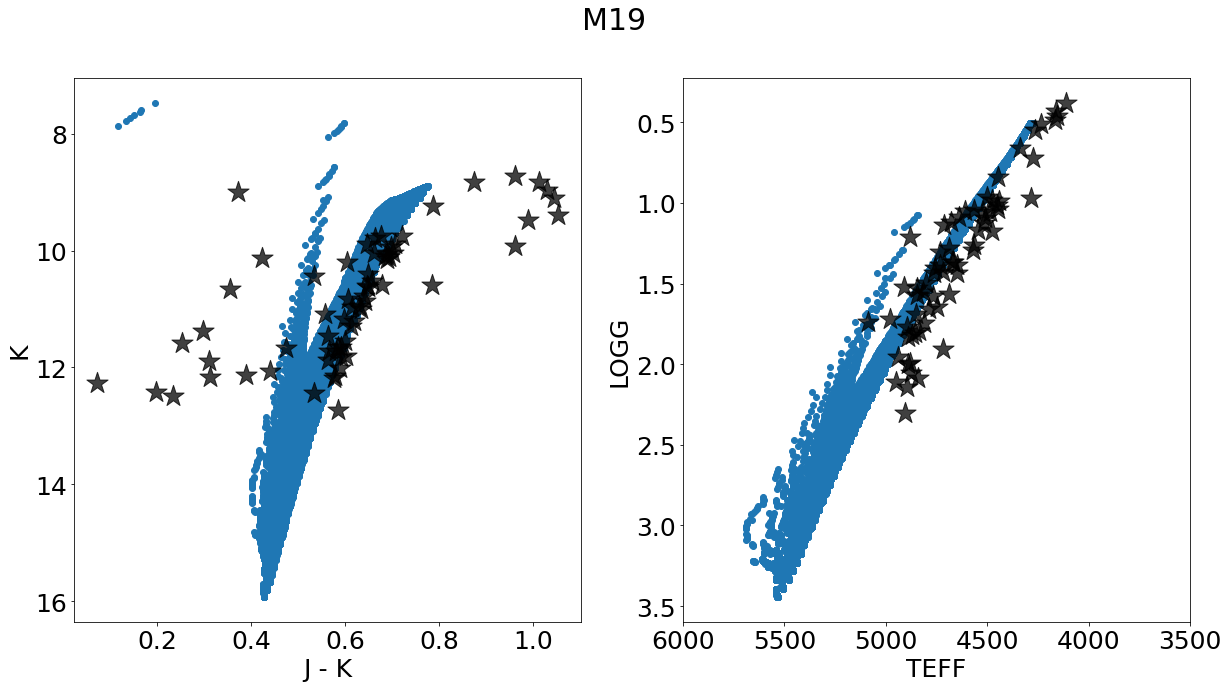

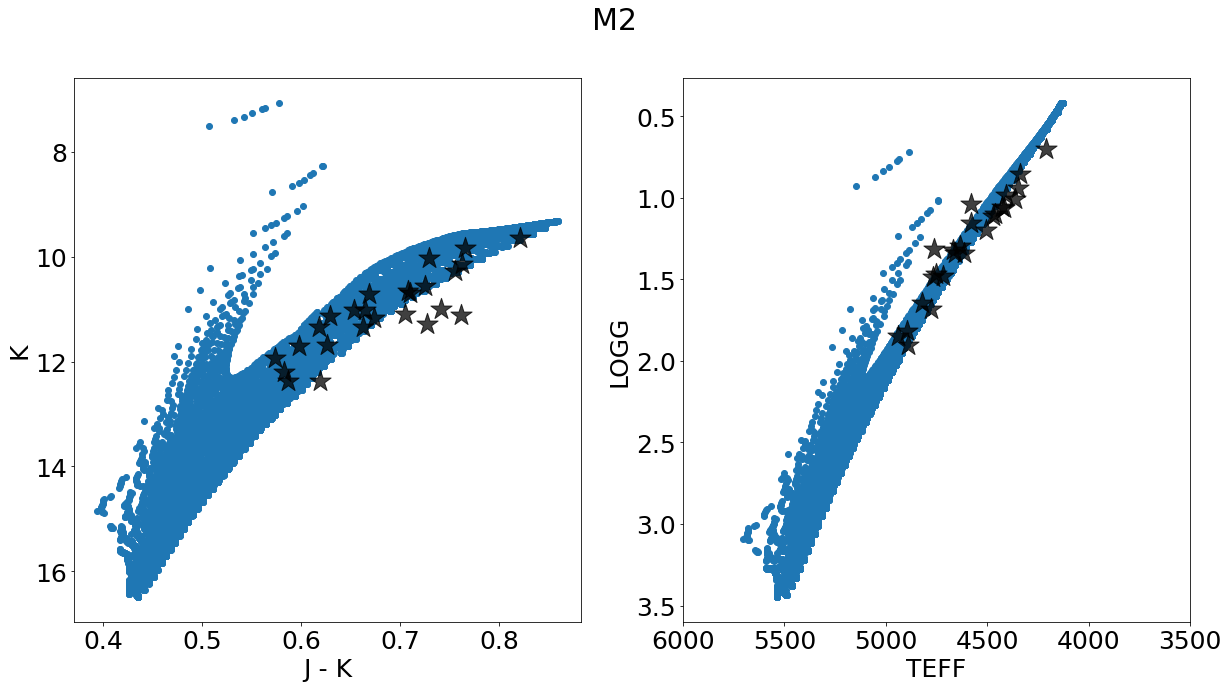

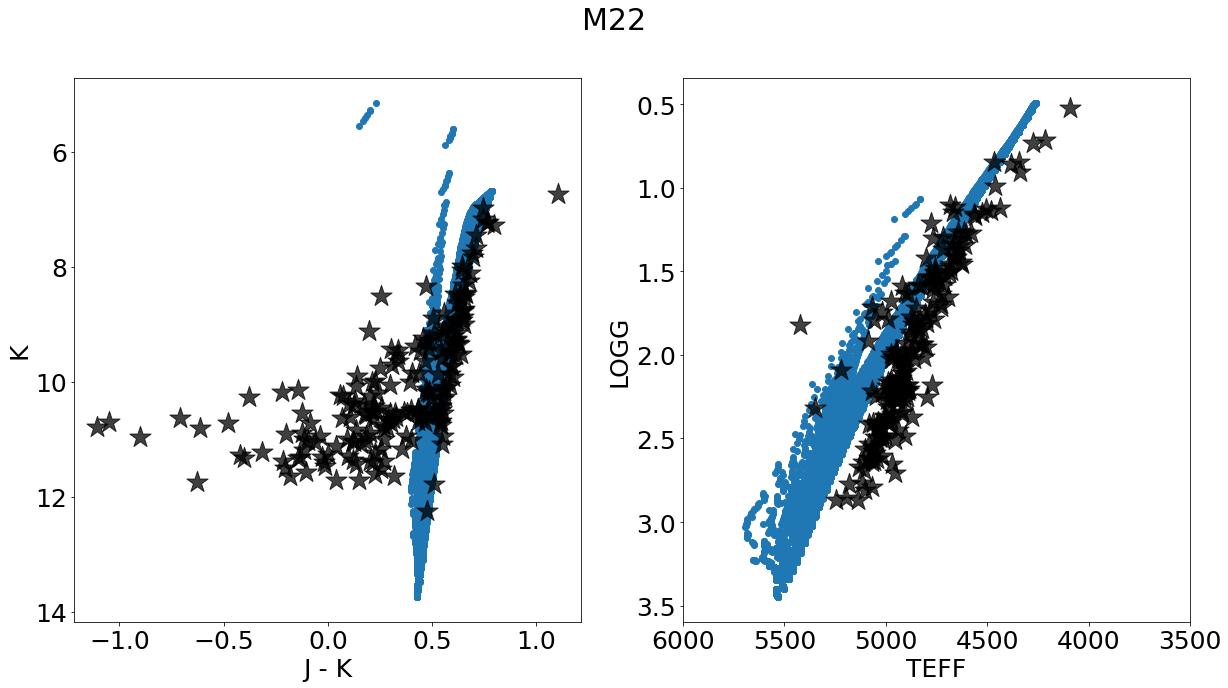

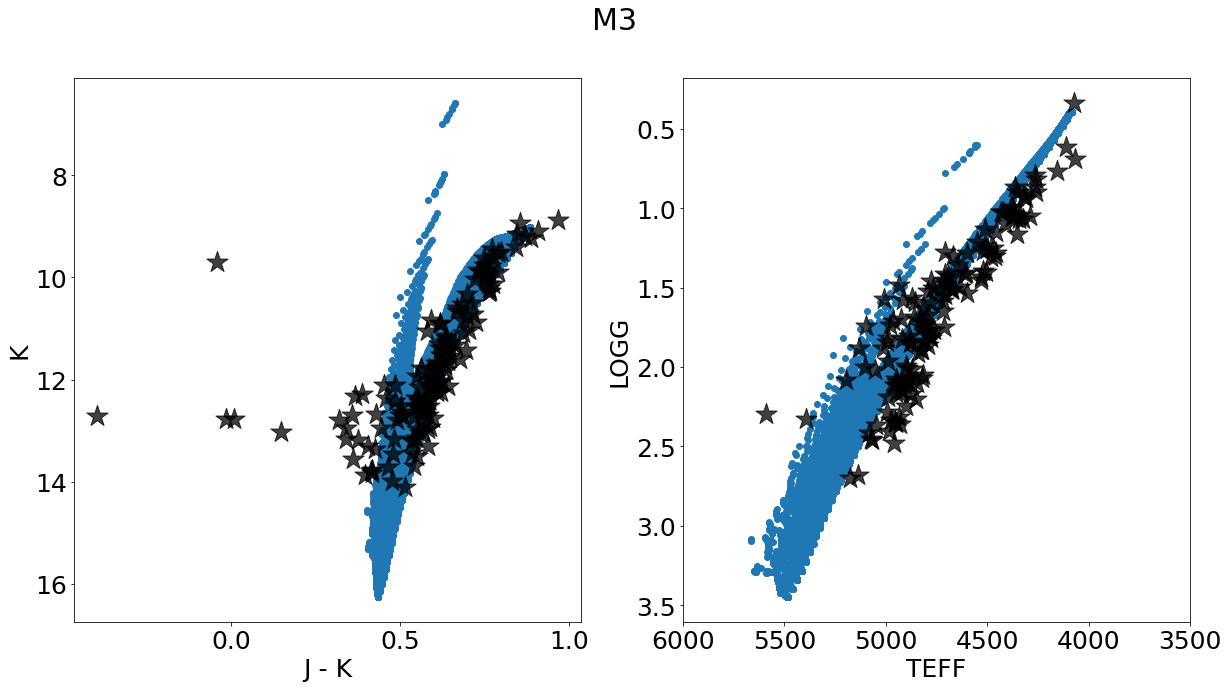

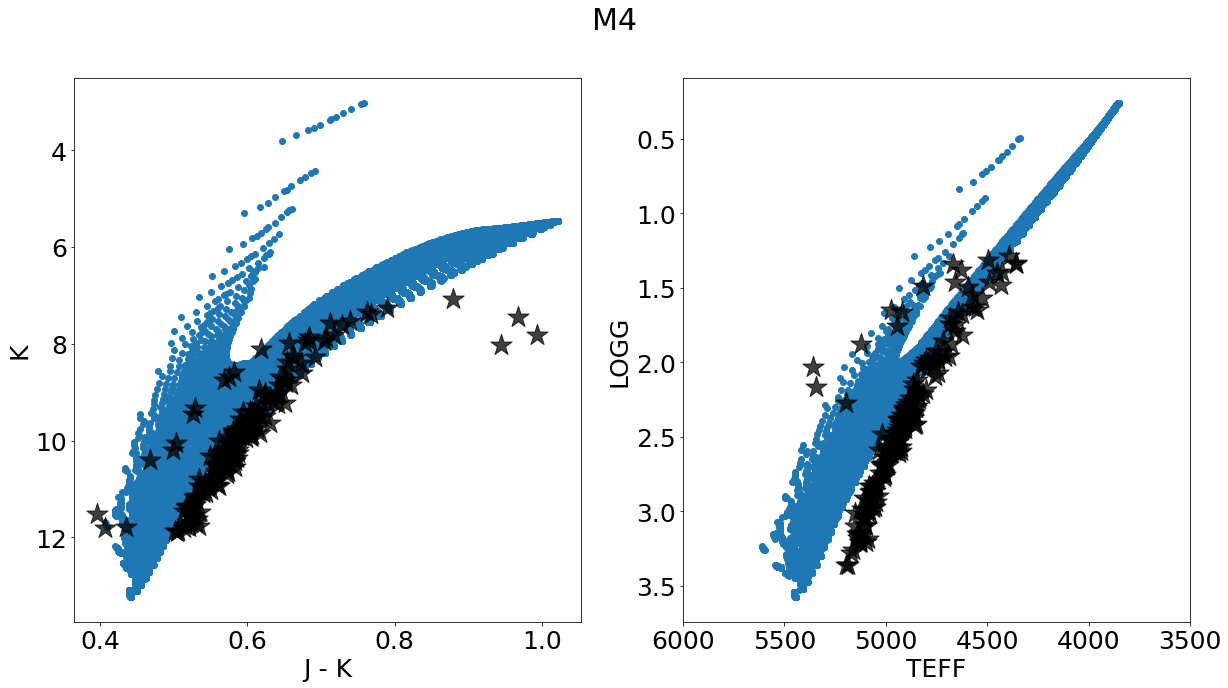

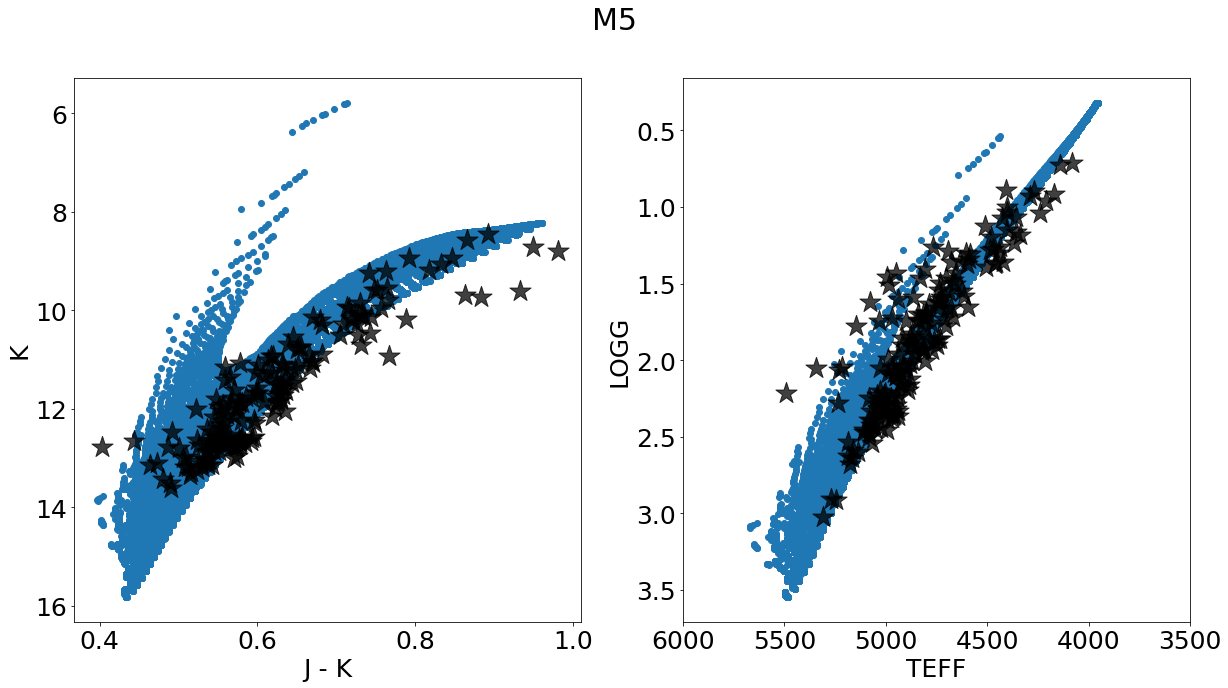

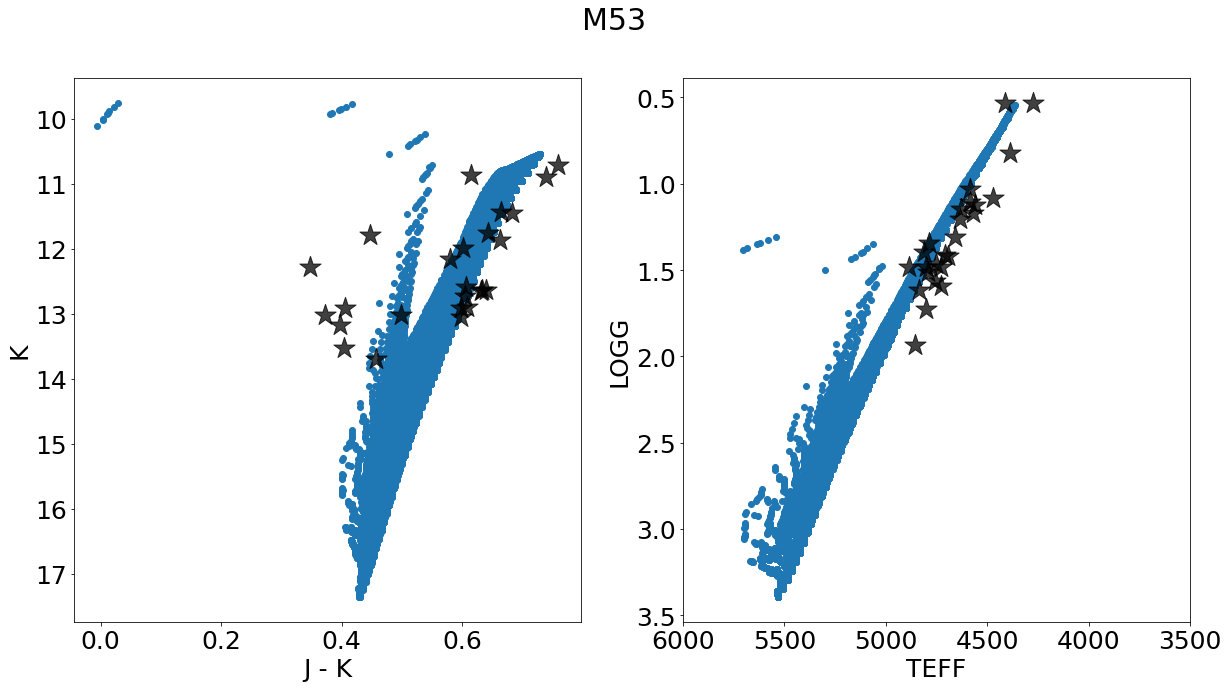

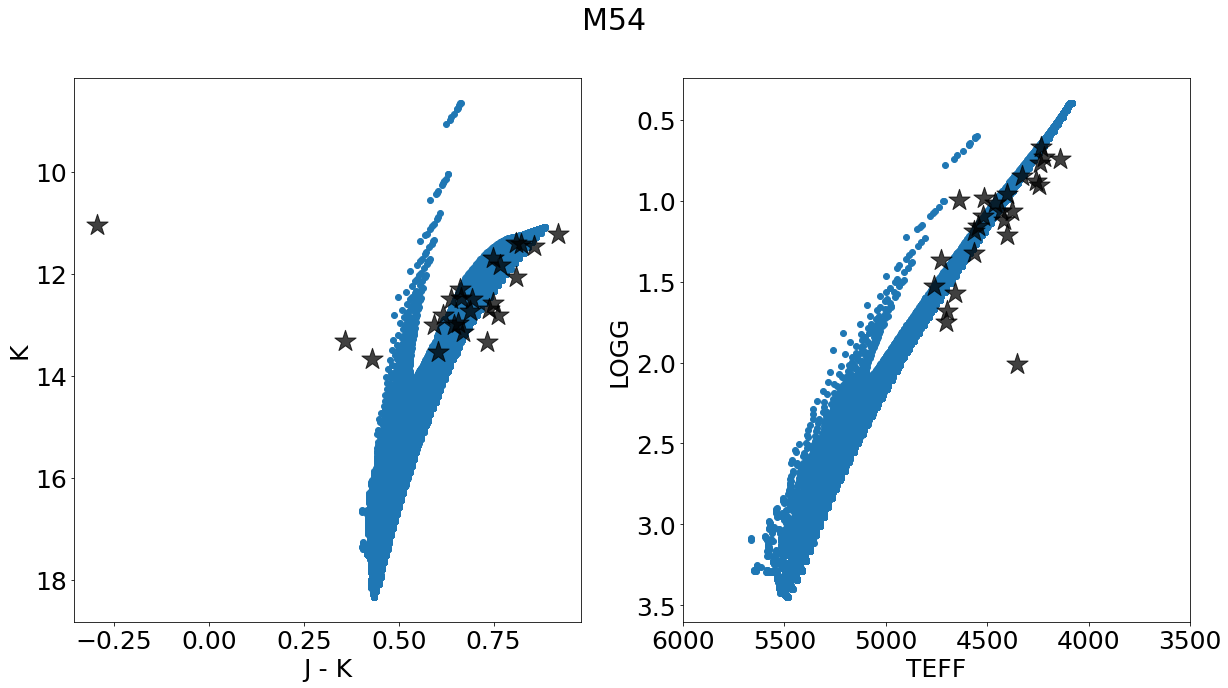

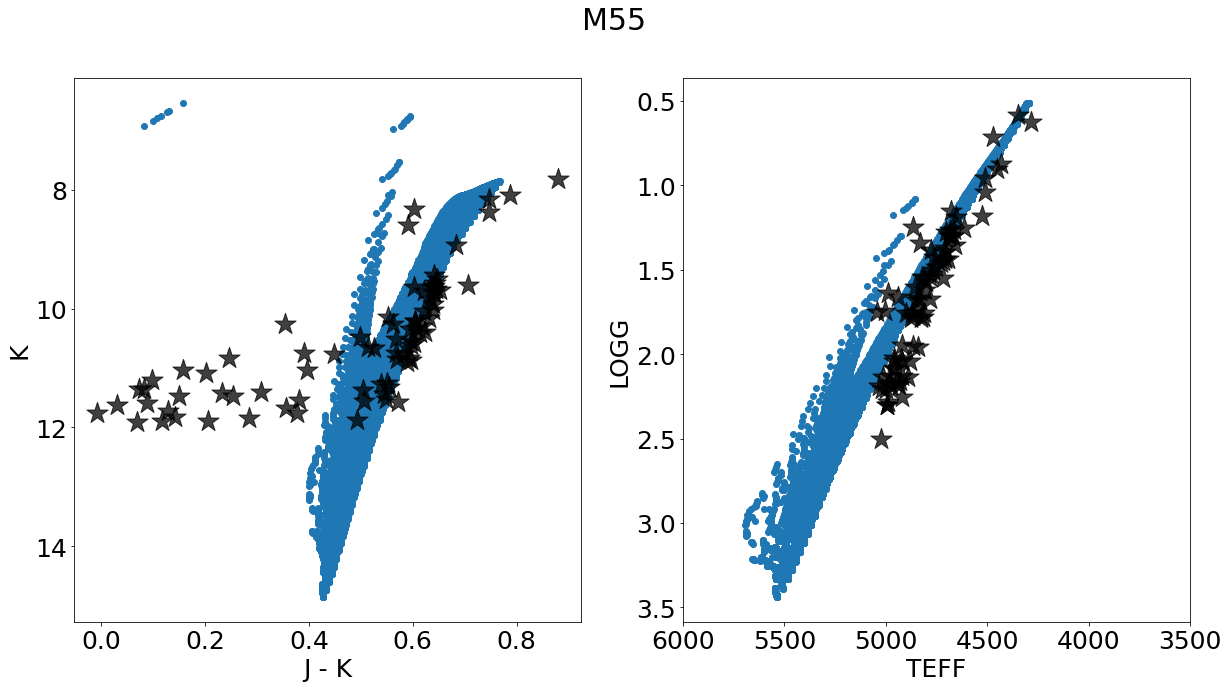

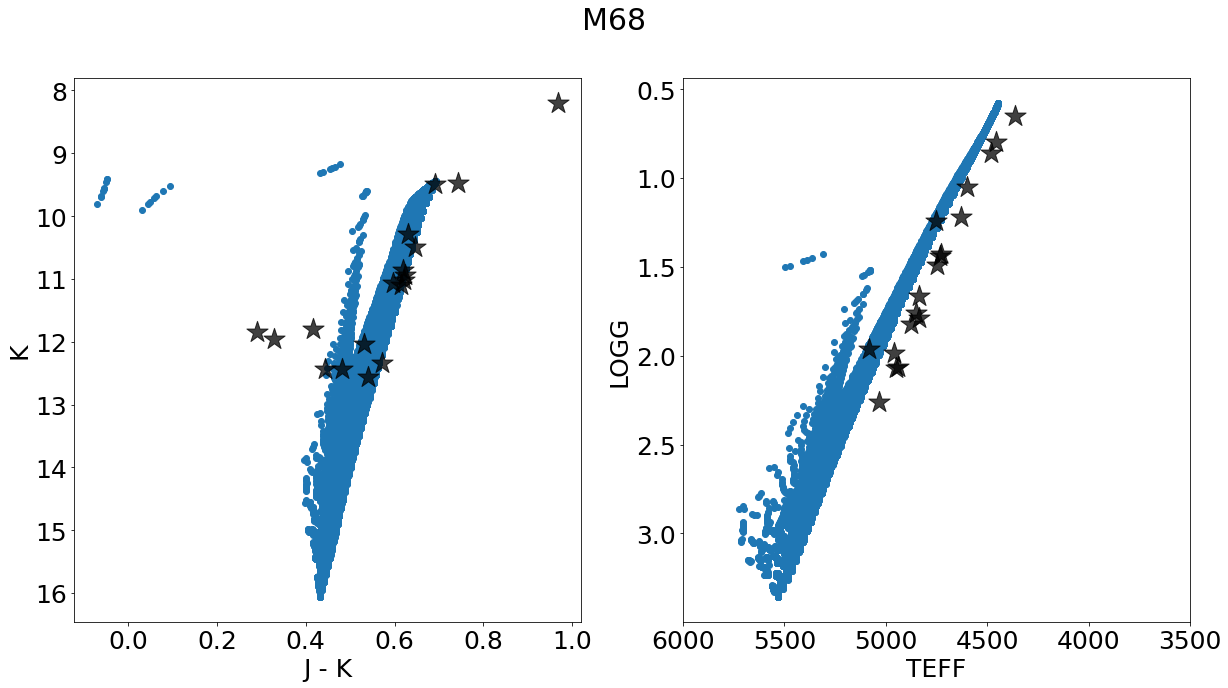

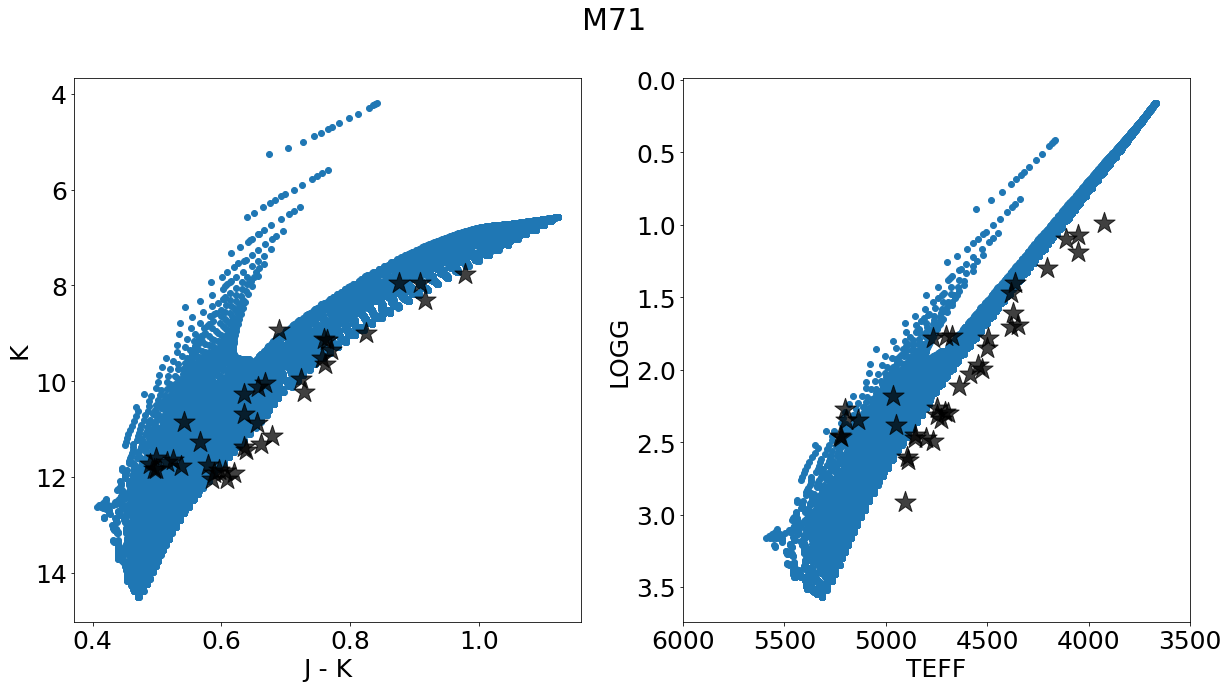

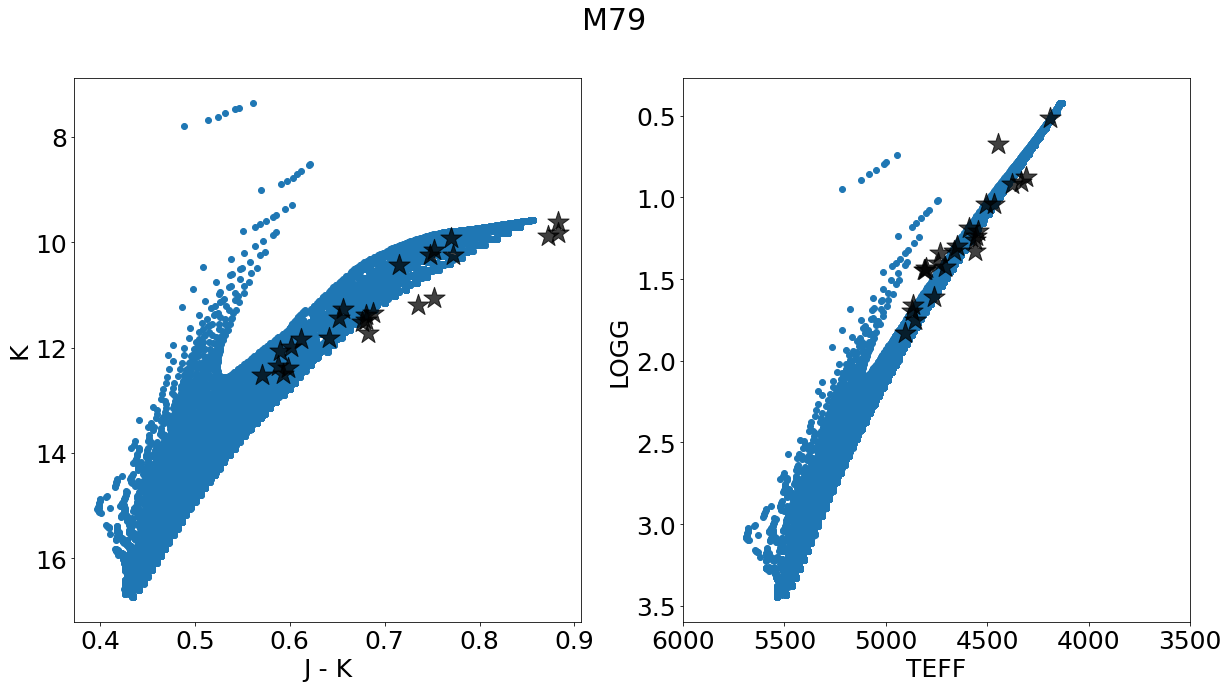

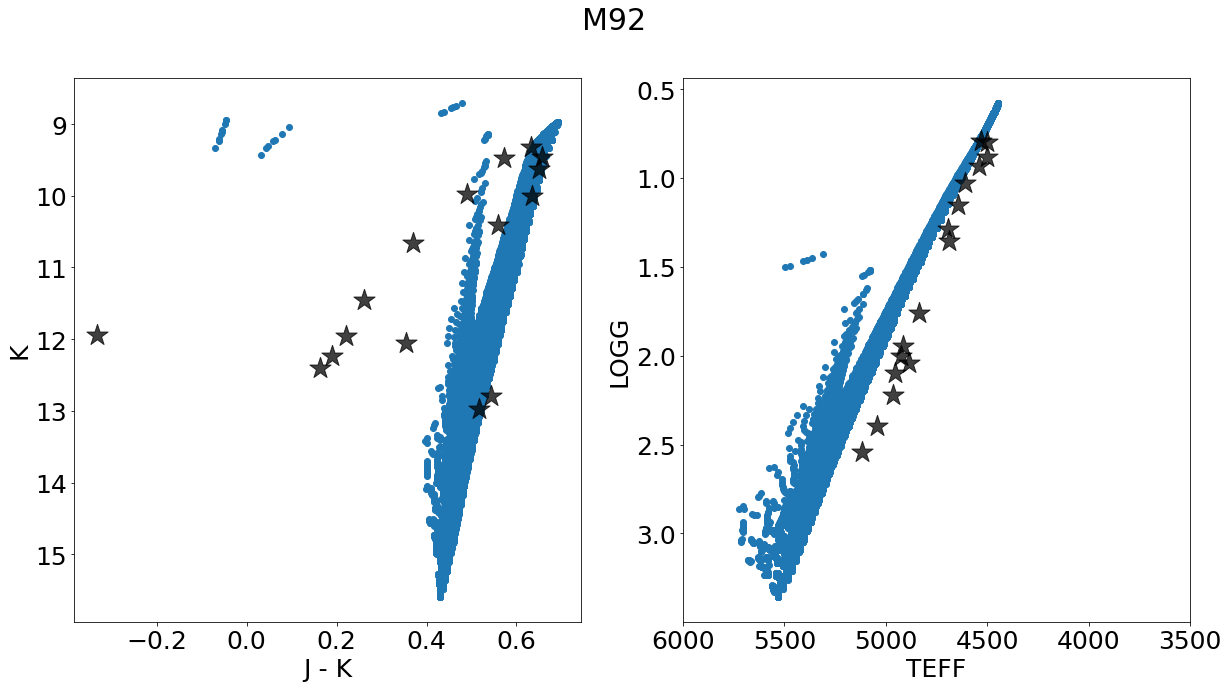

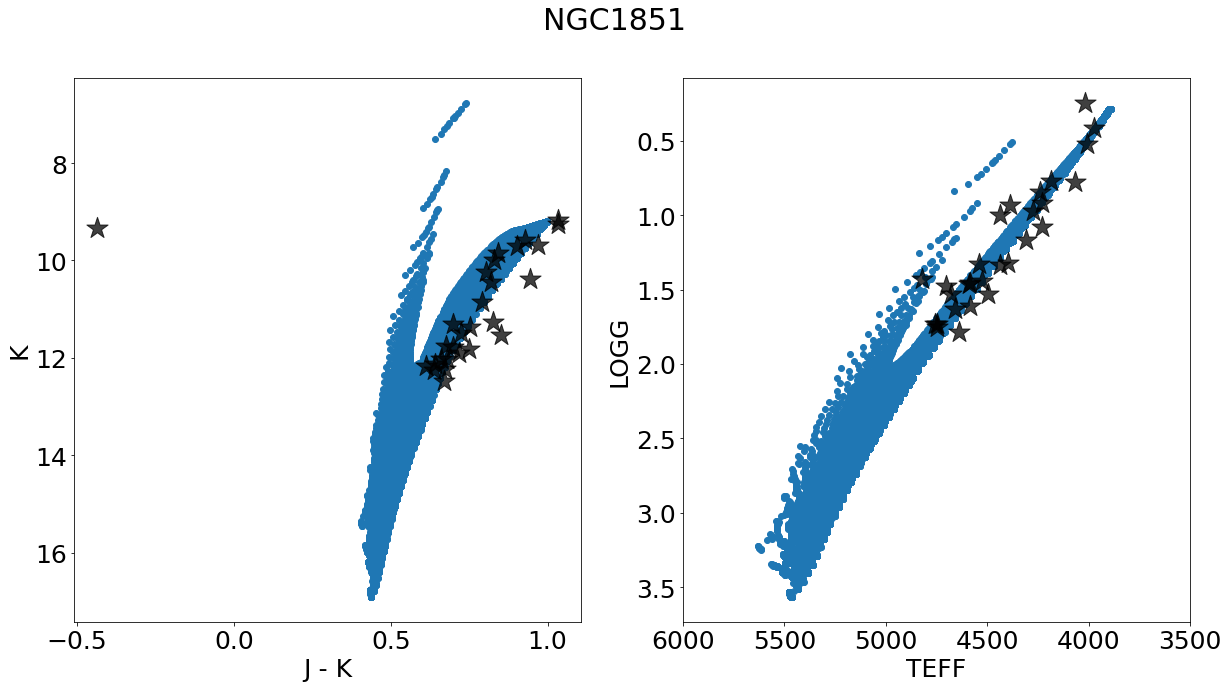

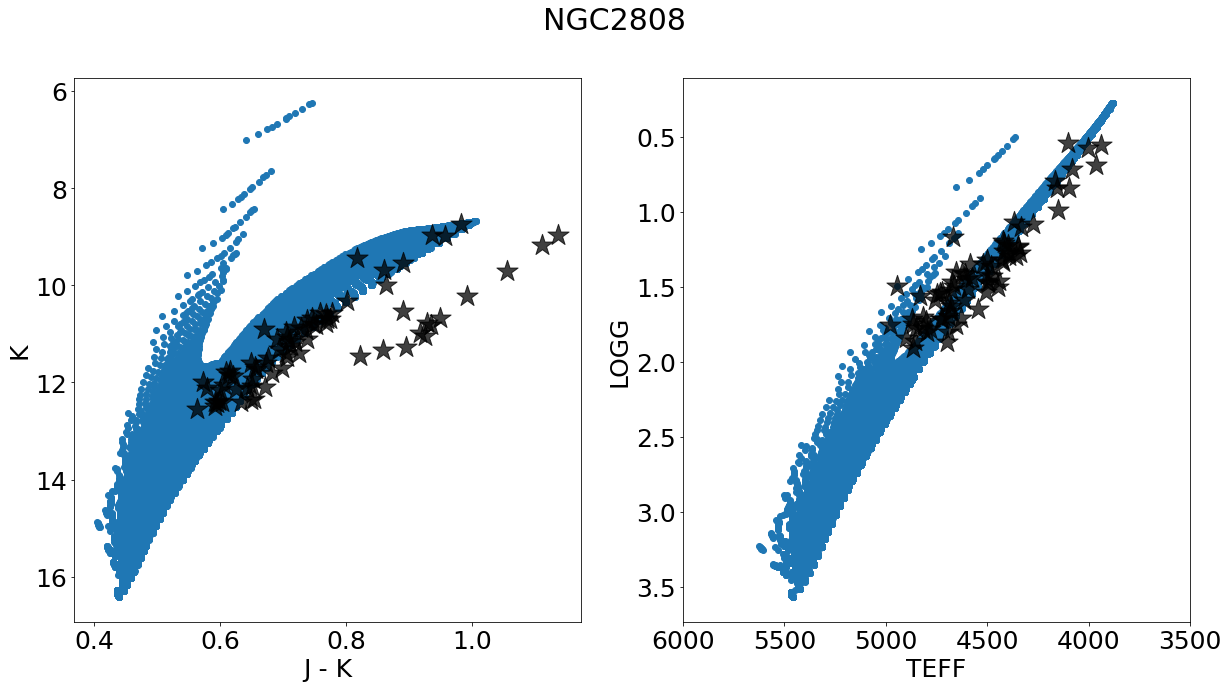

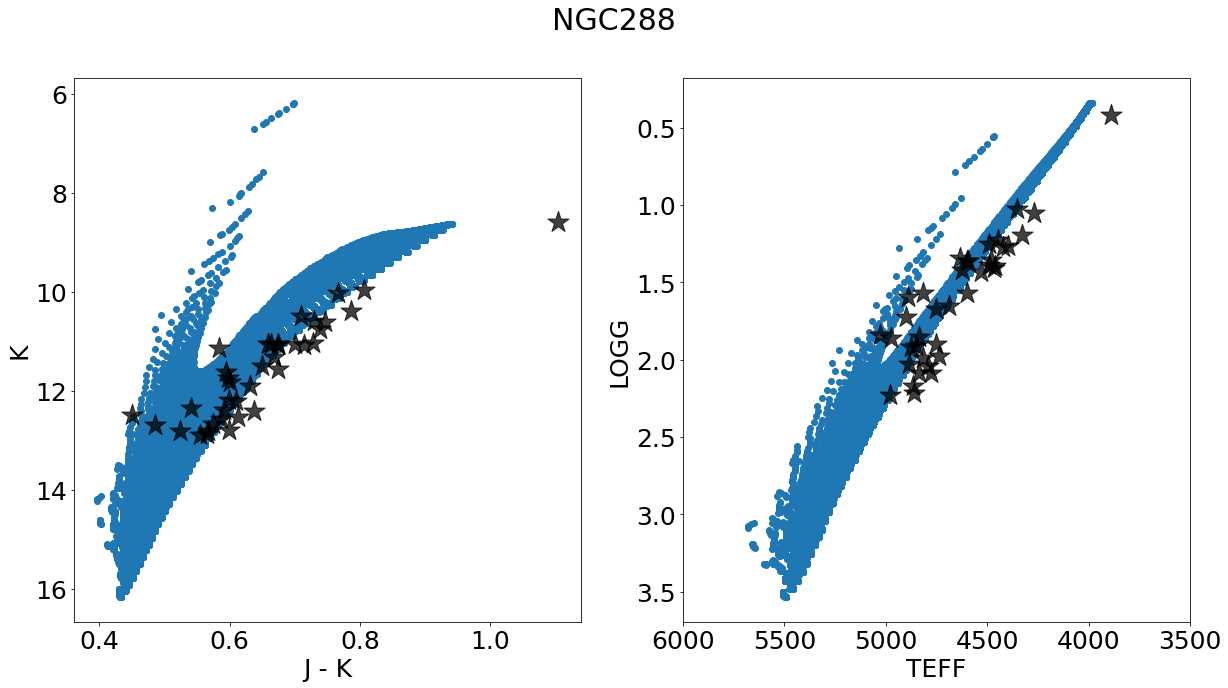

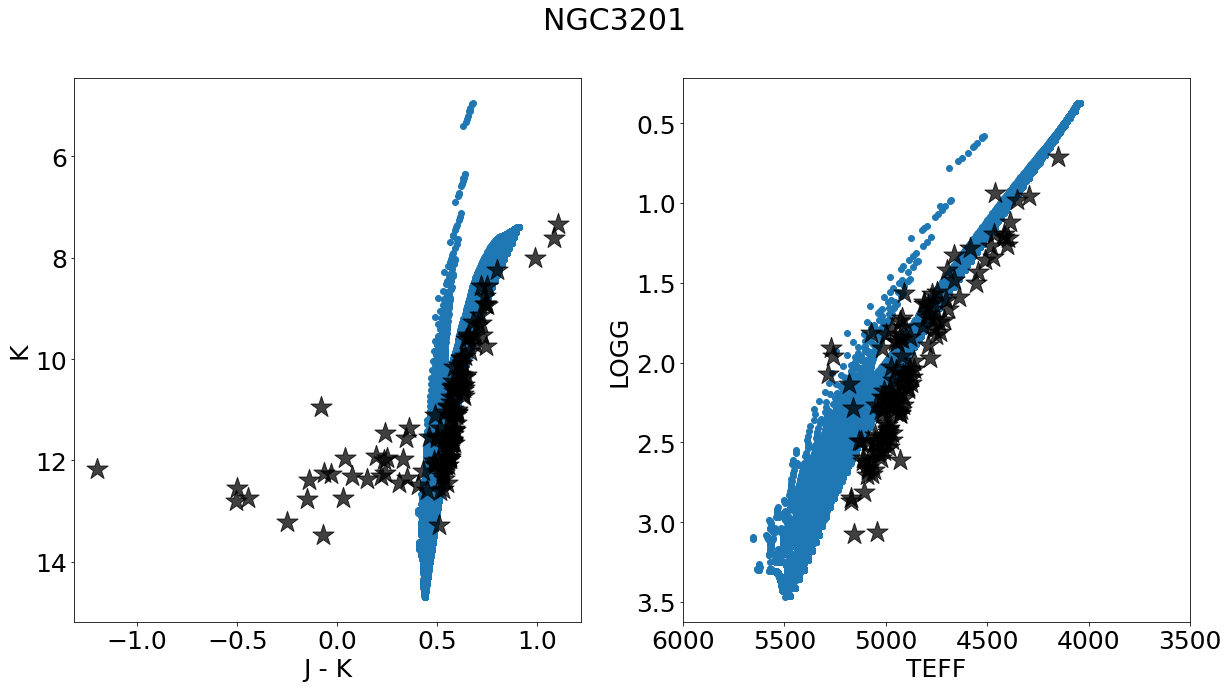

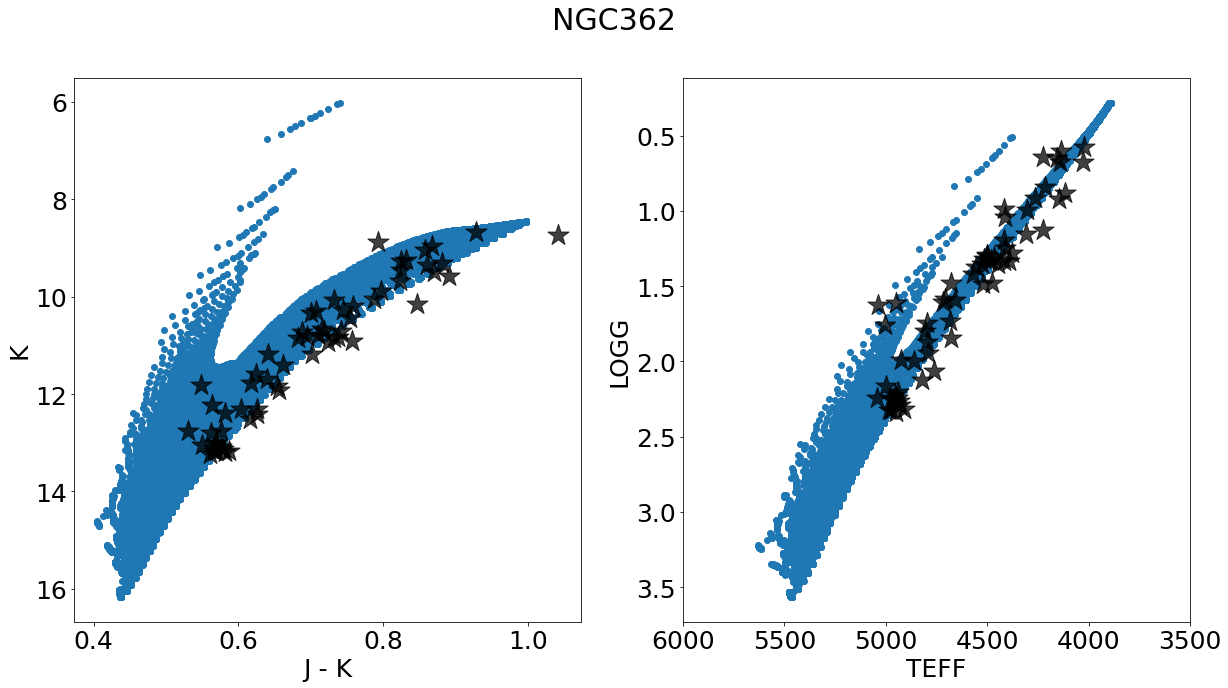

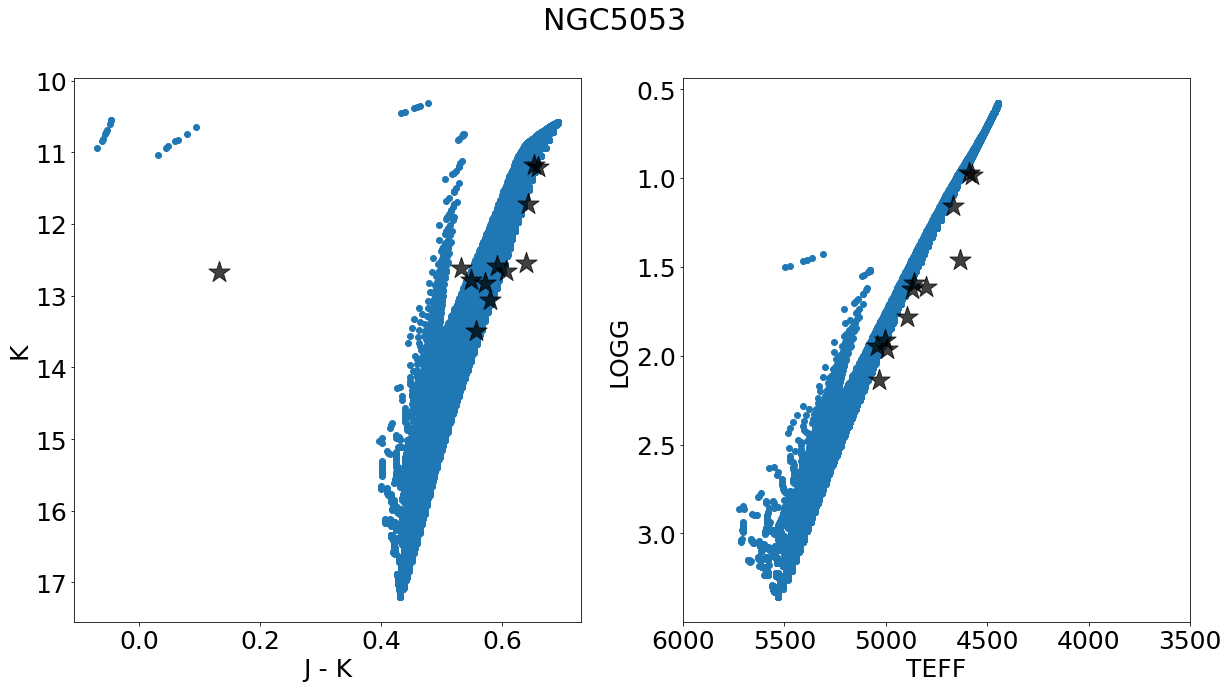

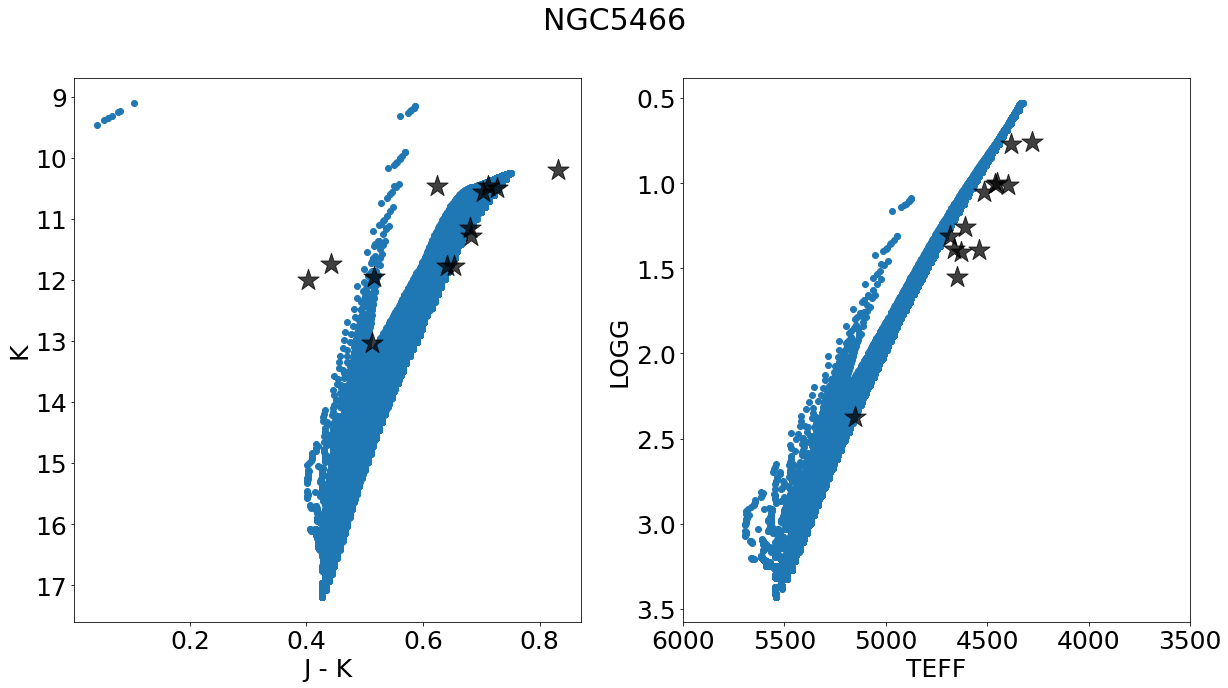

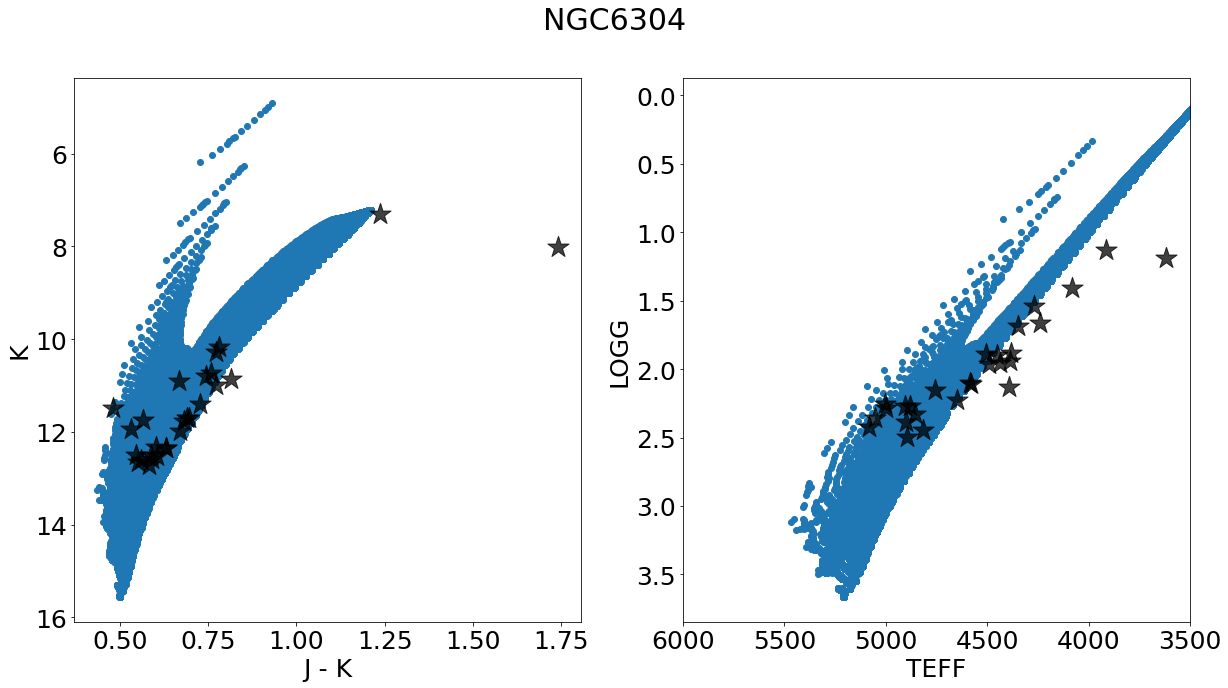

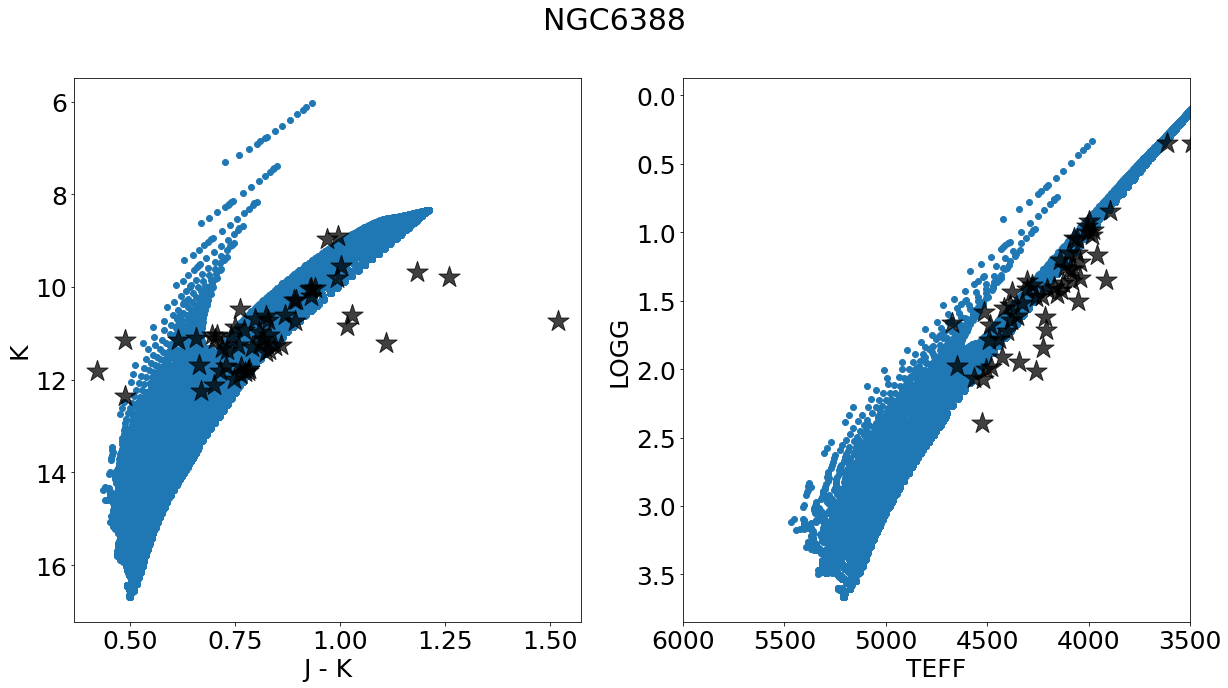

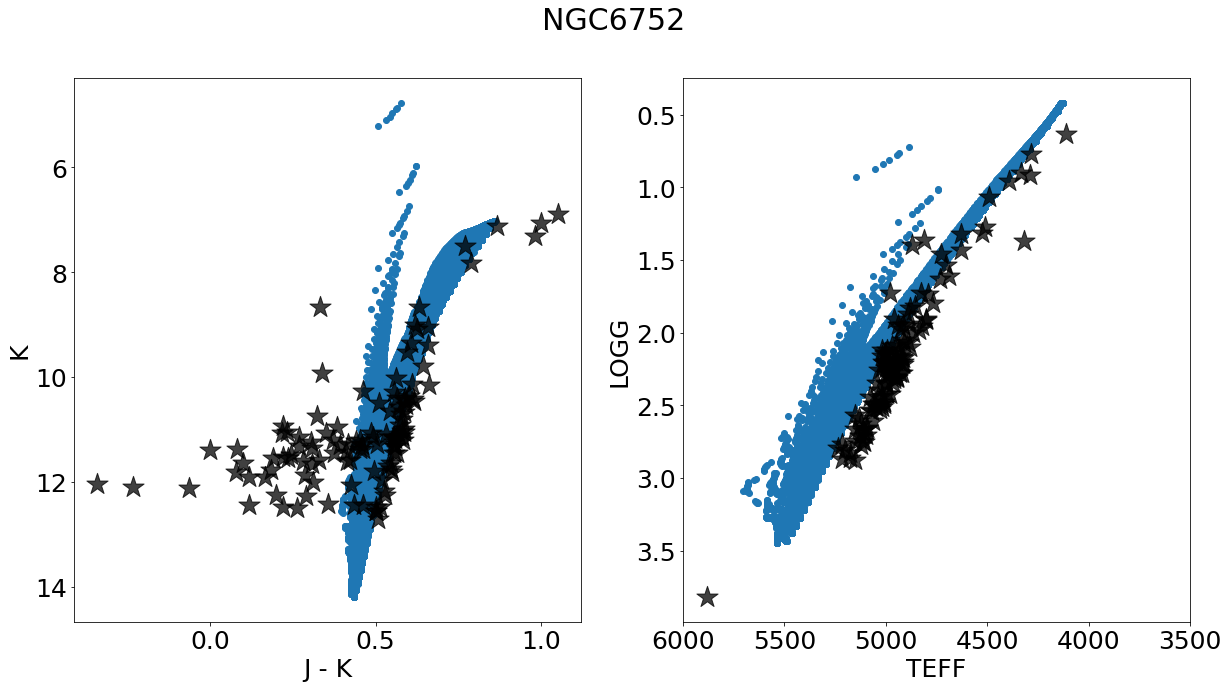

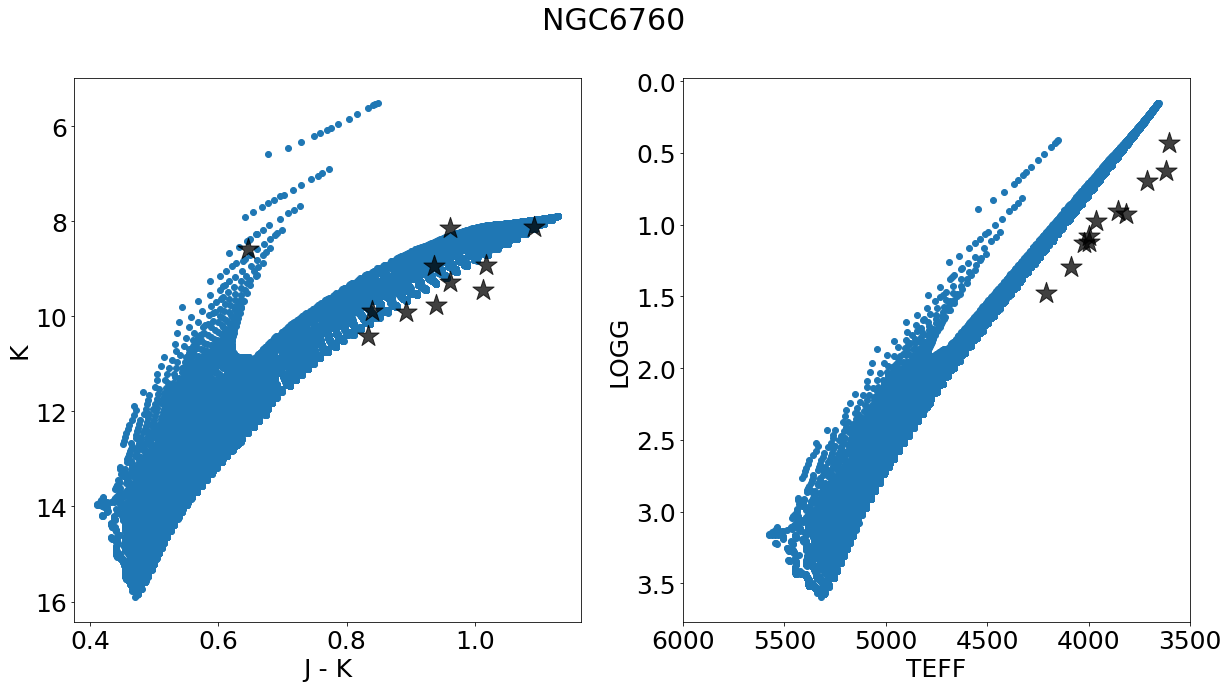

In [40]:
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(best_aks!=999999.0))
    isopick = np.where(massive['MH']==closest(massive['MH'],np.median(shiftfeh[clus])))
    
    fig, ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter((massive['Jmag']-massive['Ksmag'])[isopick],
                  massive['Ksmag'][isopick]+5.*np.log10(harris_dist[i])-5.0,cmap='tab20',zorder=0)
    ax[0].scatter((gcsdr17['J']-gcsdr17['K']-best_aks*ejk_ak)[clus],gcsdr17['K'][clus]-best_aks[clus],c='k',
                  marker='*',s=500,zorder=1,alpha=0.75)
    ax[0].invert_yaxis()
    ax[0].set_xlabel(r'J - K')
    ax[0].set_ylabel(r'K')
    
    ax[1].scatter(10**massive['logTe'][isopick],massive['logg'][isopick],cmap='tab20',zorder=0)
    ax[1].scatter(gcsdr17['TEFF'][clus],gcsdr17['LOGG'][clus],c='k',marker='*',s=500,zorder=1,alpha=0.75)
    ax[1].set_xlim(3500,6000)
    ax[1].set_xlabel(r'TEFF')
    ax[1].set_ylabel(r'LOGG')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    
    plt.suptitle(r'{}'.format(gcs_clus[i]))
#     plt.savefig('{}CMDHR.pdf'.format(gcs_clus[i]),bbox_inches='tight')
#     plt.title(r'K, J - K; {}; Color as Age'.format(gcs_clus[i]))
    plt.show()

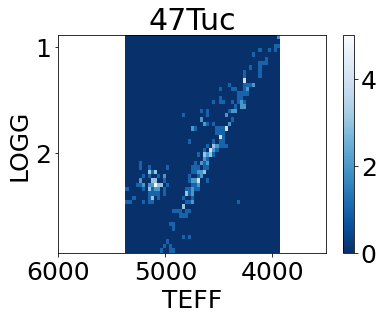

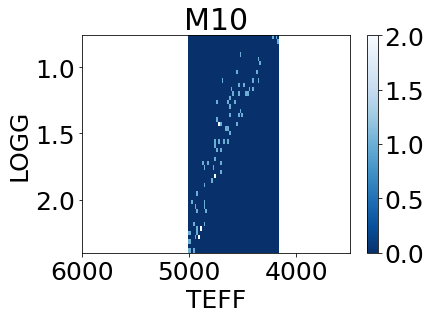

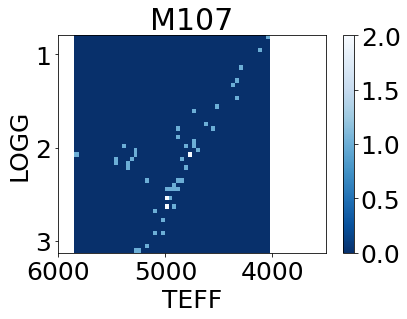

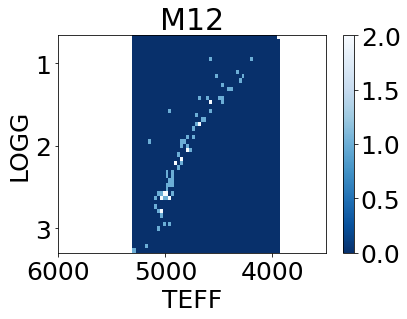

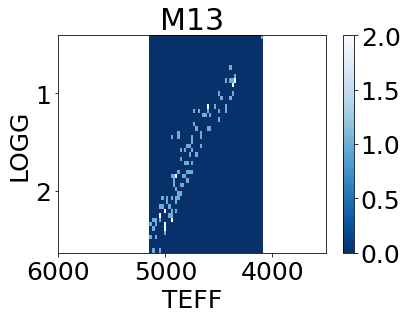

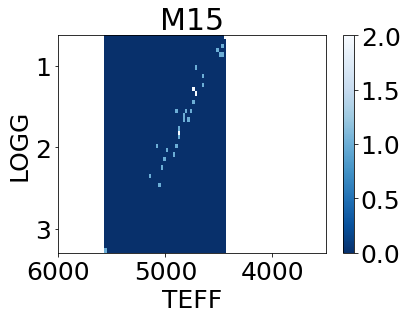

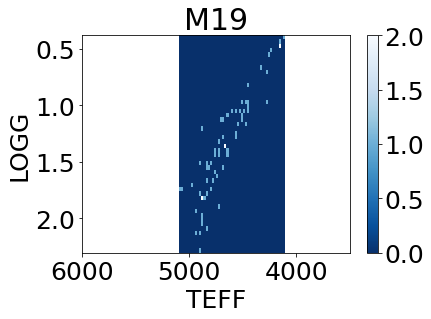

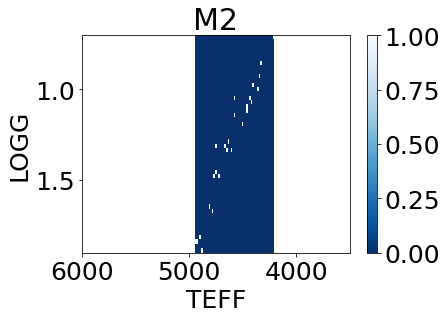

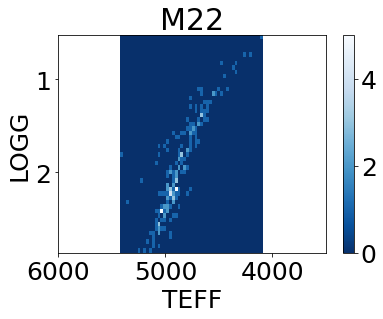

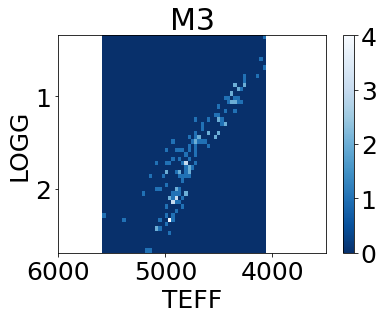

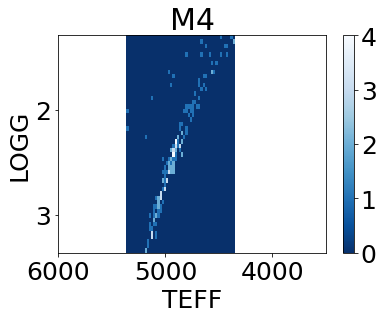

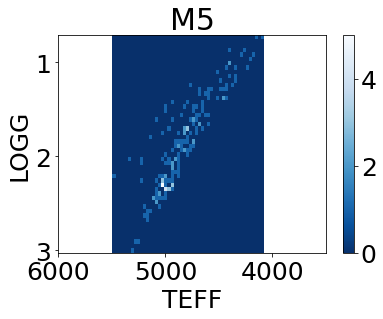

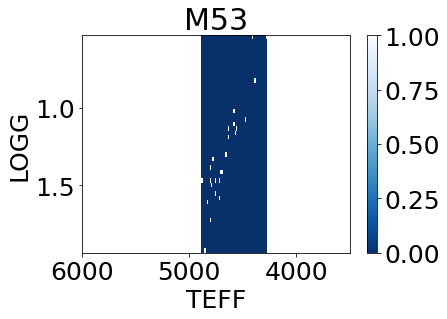

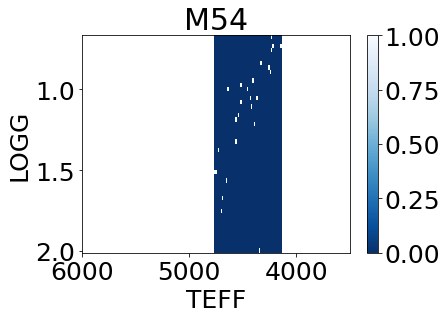

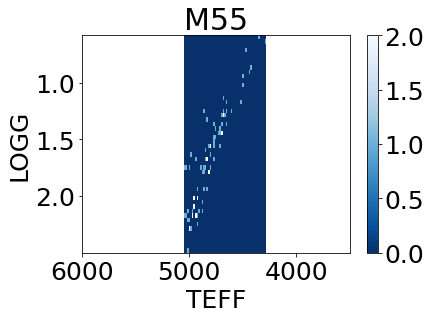

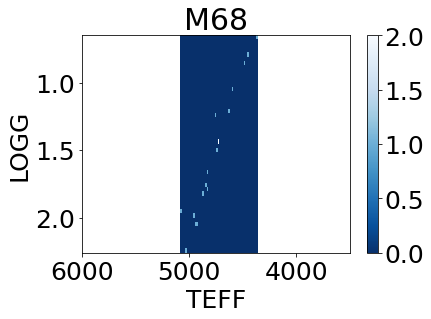

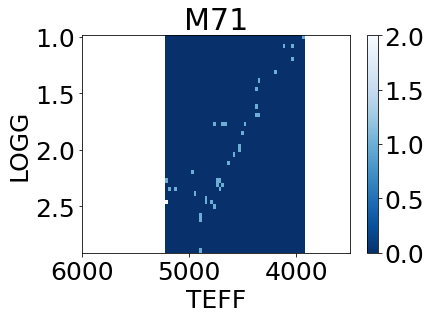

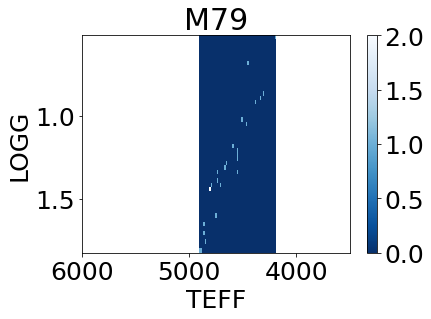

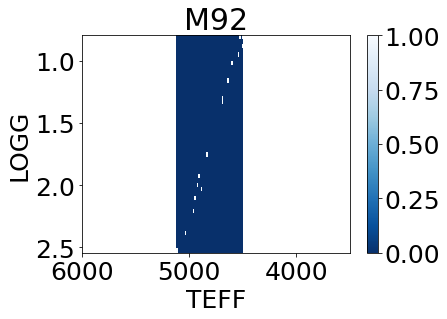

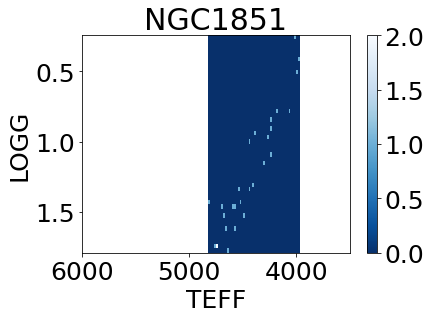

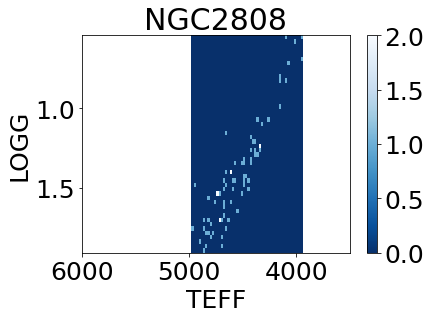

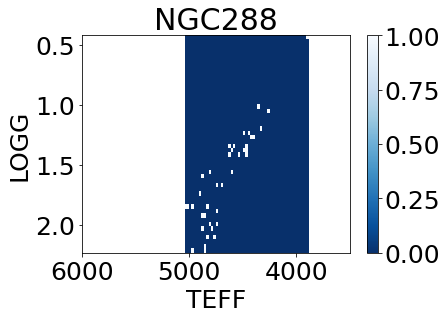

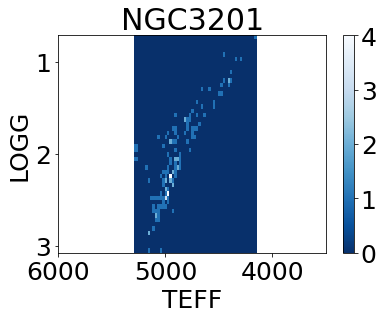

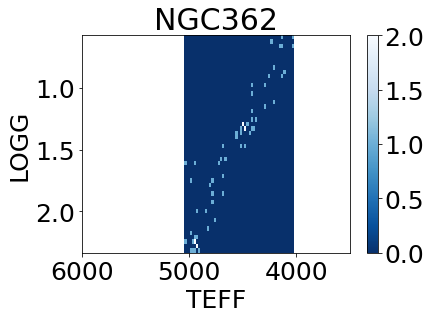

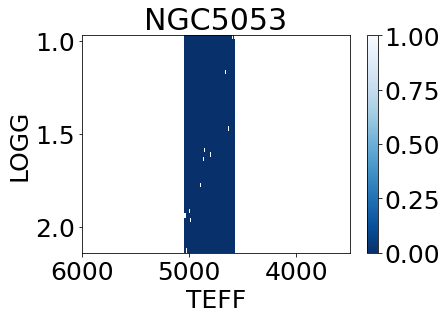

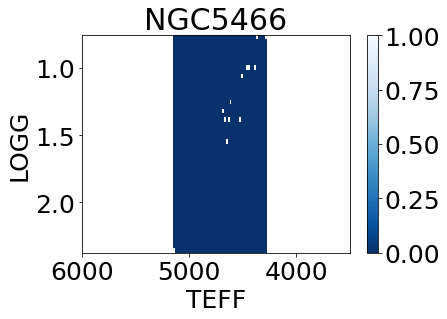

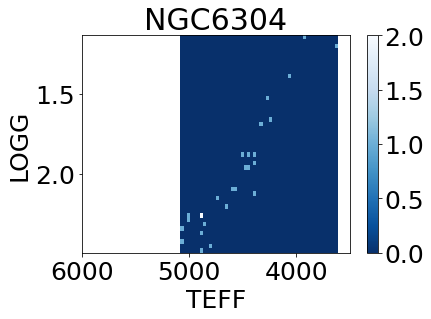

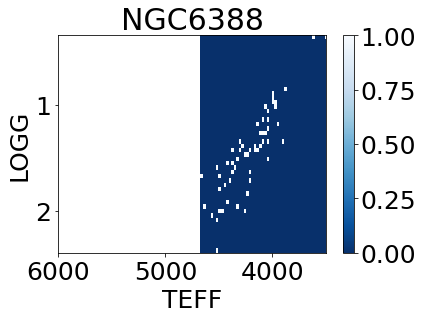

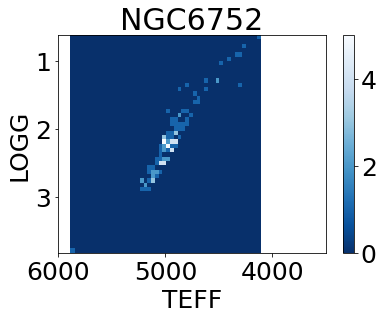

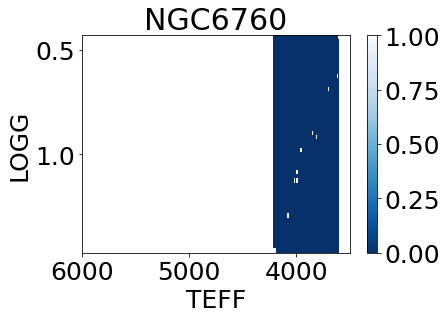

In [62]:
# for i

# plt.figure(figsize=[12,10])
# plt.hist2d(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),bins=binnum,density=True,cmin=0.01,
#            cmap='Blues_r')
# plt.colorbar()

# plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue')
# plt.ylim(bottom=-3.0)

for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(best_aks!=999999.0))
    plt.hist2d(gcsdr17['TEFF'][clus],gcsdr17['LOGG'][clus],bins=50,cmap='Blues_r')
    plt.colorbar()
    plt.xlim(3500,6000)
    plt.xlabel(r'TEFF')
    plt.ylabel(r'LOGG')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    plt.title(r'{}'.format(gcs_clus[i]))
    plt.show()